In [3]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import numba
import math

import astropy.io.fits as fits
import lmfit
from scipy.interpolate import interp1d
import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from astropy.modeling import models

def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
reset_plt(16, 20)

def forbidden(ax): 
    top = 10
    #define telluric region
    ax.fill_between([13100, 14400], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.2 )
    ax.fill_between([17550, 19200], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.2 )

    #poorly constrained regions
    ax.fill_between([5330, 5740], [-5*10**(-16)*fac, -5*10**(-16)*fac] , [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.2   )
    ax.fill_between([9940, 10200], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.2  )

    #define absorbtion feature
    #ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
    ax.fill_between([3000, 4000], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.2  )


#@numba.njit(fastmath=True)
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
#plt.plot( np.linspace(3800e-10, 10000e-10) , temp(np.linspace(3800e-10, 10000e-10), 5000) )

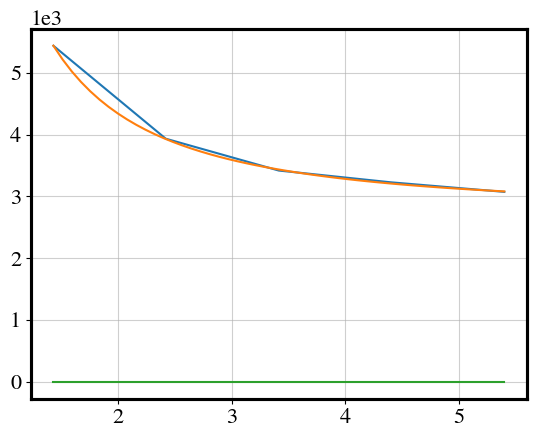

In [4]:
T = np.array([5440.8967947121055,
 3935.619453803755,
 3419.5184704387616,
 3229.356686107796,
 3074.4490750302894])

N = np.array([1.3338150746859284e-29,
 2.752046990957482e-29,
 3.6499222422992864e-29,
 3.129516127585633e-29,
 3.609077688618241e-29])
n_days = [1.427, 2.417, 3.413, 4.40, 5.40]

T_interp = interp1d(n_days, T)(4.9)
N_interp = interp1d(n_days, N)(4.9)

#plt.plot( np.linspace(3300, 22500), 1.8*N_interp*temp(np.linspace(3300, 22500)*1e-10,T_interp) )

plt.plot(n_days, T)

def powerlaw_with_constant(x,a,b,c): 
    return a*x**(b) + c

from scipy.optimize import curve_fit

p0,_ = curve_fit(powerlaw_with_constant, n_days, T, p0 = [2000, -1, 2700])
plt.plot( np.linspace(min(n_days), max(n_days)), 
         powerlaw_with_constant( np.linspace(min(n_days), max(n_days)), *p0) )

t6 = powerlaw_with_constant( 6.4, *p0)
t7 = powerlaw_with_constant( 7.4, *p0)

plt.plot(n_days, N)

def powerlaw(x,a,b): 
    return a*x**(b) 

from scipy.optimize import curve_fit

pN,_ = curve_fit(powerlaw, n_days[1:], N[1:], p0 = [0.5e-29, 0.9])
#plt.plot( np.linspace(min(n_days), max(n_days)), 
#         powerlaw( np.linspace(min(n_days), max(n_days)), *pN) )

N6 = powerlaw( 6.4, *pN)
N7 = powerlaw( 7.4, *pN)

## Functions and fitting

In [5]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)        
        wl_out[h_index] = np.mean(wl[ii:ii + binh], axis=0)

        #
        #res[h_index] = np.median(flux[ii:ii + binh]) 
        
    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)


In [6]:
def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #def integral(x): 
    #    return np.sqrt(1-v**2) * 1/(1+v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

    #corr = np.zeros_like(vphot)
    #for i,v in enumerate(vphot):
    #    delta = quad(integral, 0, np.pi/2)[0]
    #    corr[i] = delta**4
    delta = 1-2/3*11/10*vphot
    corr = delta**4
    
    theta = 2*np.sqrt(corr*N*10**(7)/(1-vphot))

    v = vphot*c #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23)
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]
fac = 1e16

from dust_extinction.parameter_averages import F04
from extinction import ccm89
import astropy.units as u

ext = F04(Rv=3.1)
#reddening_n = ( ext.extinguish(wav_ANU*u.angstrom, Ebv=0.11))


Binning image by a factor: 10
3615.0 6932.4
Binning image by a factor: 20


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 20


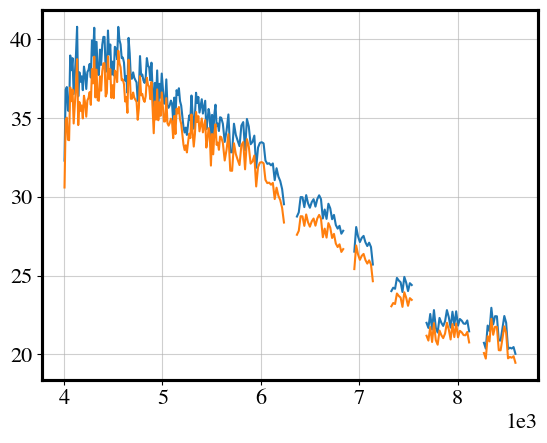

In [7]:
wl_LDSS3, flux_LDSS3 = np.loadtxt('SSS17a-LDSS3-20170817_cal.flm').T
exc_reg = (~((wl_LDSS3 > 7550) & (wl_LDSS3 < 7670))) #&  (~((wav > 6800) & (wav < 6950))) 
wl_LDSS3, flux_LDSS3,_,_ = bin_spectrum(wl_LDSS3, flux_LDSS3, np.ones_like(flux_LDSS3), ~exc_reg, 10)

reddening_n = ( ext.extinguish(wl_LDSS3*u.angstrom, Ebv=0.11))

extinction_ccm = ccm89(wl_LDSS3, 0.12*3.1, 3.1)  # The second argument is the Rv value
reddening_ccm = 10**(-0.4 * extinction_ccm)
red_corr = (reddening_n/reddening_ccm)**(-1)
flux_LDSS3 = flux_LDSS3*red_corr


wl_MagE, flux_MagE = np.loadtxt('SSS17a-MagE-20170817_cal.flm').T
print(np.min(wl_MagE), np.max(wl_MagE))
exc_reg = (~((wl_MagE > 7550) & (wl_MagE < 7670))) #&  (~((wav > 6800) & (wav < 6950))) 
wl_MagE, flux_MagE,_,_ = bin_spectrum(wl_MagE, flux_MagE, np.ones_like(flux_MagE), ~exc_reg, 20)

reddening_n = ( ext.extinguish(wl_MagE*u.angstrom, Ebv=0.11))
extinction_ccm = ccm89(wl_MagE, 0.12*3.1, 3.1)  # The second argument is the Rv value
reddening_ccm = 10**(-0.4 * extinction_ccm)
red_corr = (reddening_n/reddening_ccm)**(-1)
flux_MagE = flux_MagE*red_corr


#wl_LDSS3b, flux_LDSS3b = np.loadtxt('SSS17a-LDSS3b-20170817_cal.flm').T
#wl_LDSS3r, flux_LDSS3r = np.loadtxt('SSS17a-LDSS3r-20170817_cal.flm').T

filename = 'anufit_spectrum_dered.dat'
t = ascii.read(filename)
    # Rename the columns
t.rename_column("col1", "wav")
t.rename_column("col2", "flux")
    # Plot
wav = t['wav'][:-7]; flux = t['flux'][:-7]
    
flux = np.reshape(flux, (int(np.shape(flux)[0]/15), 15) )
wav = np.reshape(wav, (int(np.shape(wav)[0]/15), 15) )
flux_ANU = np.mean(flux,axis=1); wav_ANU = np.mean(wav,axis=1)
exc_reg = (~((wav_ANU > 7550) & (wav_ANU < 7670))) &  (~((wav_ANU > 6850) & (wav_ANU < 6950))) &  (~((wav_ANU > 6250) & (wav_ANU < 6360)))  &  (~((wav_ANU > 7150) & (wav_ANU < 7320))) &  (~((wav_ANU > 8120) & (wav_ANU < 8250))) &  (wav_ANU < 8600) 
wav_ANU[~exc_reg], flux_ANU[~exc_reg] = np.nan, np.nan

#plt.axvline(8120)
#plt.axvline(8250)
#plt.axvline(7150)
#plt.axvline(7320)
#plt.axvline(6350)
#plt.axvline(6250)
plt.plot(wav_ANU, flux_ANU)

# initialize the model
ext = F04(Rv=3.1)
reddening_n = ( ext.extinguish(wav_ANU*u.angstrom, Ebv=0.11))
    
# Extinction model (Cardelli, Clayton, & Mathis 1989)
extinction_ccm = ccm89(wav_ANU, 0.12*3.1, 3.1)  # The second argument is the Rv value
reddening_ccm = 10**(-0.4 * extinction_ccm)
#reddening_0 = ccm89(wav*u.angstrom, 0.12, 3.1) 
red_corr = (reddening_n/reddening_ccm)**(-1)
flux_ANU = flux_ANU*red_corr
plt.plot(wav_ANU, flux_ANU)


wl_SALT,f_SALT,fe_SALT = np.loadtxt('SALT_Crawford.txt').T
exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) #&  (~((wav > 6800) & (wav < 6950))) 
wl_SALT,f_SALT,fe_SALT,_ = bin_spectrum(wl_SALT,f_SALT,fe_SALT, ~exc_reg, 20)

extinction_ccm = ccm89(wl_SALT, 0.12*3.1, 3.1)  # The second argument is the Rv value
reddening_ccm = np.ones_like(extinction_ccm)#10**(-0.4 * extinction_ccm)
reddening = ( ext.extinguish(wl_SALT*u.angstrom, Ebv=0.11) )
f_SALT = f_SALT*(reddening_ccm/reddening)

#f_SALT = f_SALT[exc_reg]
#wl_SALT = wl_SALT[exc_reg]

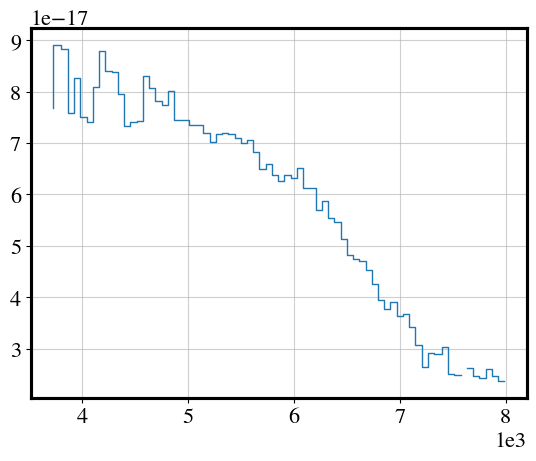

In [8]:
plt.plot(  wl_SALT, f_SALT, ds='steps', linewidth=1)


Binning image by a factor: 10


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/229042

(3800.0, 11000.0)

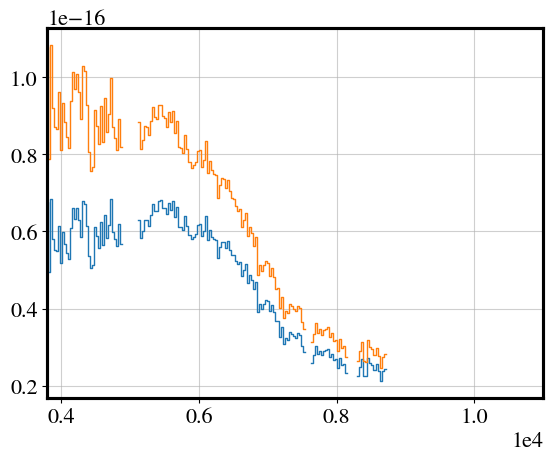

In [9]:
#for f in fits.open('ligo_oma_clfc2.fits'): 
#    head = f.header
#    data = f.data

for f in fits.open('ligo_new1_eg21.fits'): 
    head = f.header
    data = f.data

wl_SALT = 2.919*np.arange(len(data))+1574
f_SALT  = data
#exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (((wl_SALT > 3800) & (wl_SALT < 8700))) 
#exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (~((wl_SALT > 4880) & (wl_SALT < 5135))) &  (~((wl_SALT > 8170) & (wl_SALT < 8320))) & (((wl_SALT > 3800) & (wl_SALT < 9200))) 
exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (~((wl_SALT > 4880) & (wl_SALT < 5135))) &  (~((wl_SALT > 8170) & (wl_SALT < 8320))) & (((wl_SALT > 3800) & (wl_SALT < 8700))) 
wl_SALT,f_SALT,_,_ = bin_spectrum(wl_SALT,f_SALT,np.ones_like(f_SALT), ~exc_reg, 10)
plt.plot( wl_SALT, f_SALT, ds='steps', linewidth=1)

ext = F04(Rv=3.1)
reddening_n = ( ext.extinguish(wl_SALT*u.angstrom, Ebv=0.11))
f_SALT = f_SALT/reddening_n

plt.plot( wl_SALT , f_SALT, ds='steps', linewidth=1)
#plt.ylim(1e-18, 1e-16)
plt.xlim(3800, 11000)


In [10]:
35/34

1.0294117647058822

In [11]:
(1.47/1.43)**(-0.7), (1.5/1.45)**(1)

(0.9808737042368488, 1.0344827586206897)

In [12]:
fit_res = "../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl" 
pickle_in = open(fit_res,"rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p['tau'].value = 0
flux_fit_Xshooter = residual(p, wl50*1e-10)
plt.plot(wl50, flux_fit_Xshooter, color='darkred')


p['T'].value = p['T'].value*0.98
p['N'].value = p['N'].value*(1.05)**2
p['amp1'].value = 0
p['tau'].value = 0

path_VIS = 'nicholl_optical_spectra/gw170817_day1.5_SOAR_restframe_dered.txt'
lam, flam = np.loadtxt(path_VIS).T
exc_reg = (~((lam > 7510) & (lam < 7650)))
lam_op,flam_op,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 8)
plt.plot(lam_op[1:-1], flam_op[1:-1], alpha=0.5, color='C1', ds='steps')

flux_fit_op = residual(p, lam_op*1e-10)
plt.plot(lam_op, flux_fit_op, color='darkred')

path_NIR = 'CHORNOCK_NIR_final/gw170817-gemini-day1.5-dered-sca.dat'
lam, flam = np.loadtxt(path_NIR).T
exc_reg = (~((lam > 13100) & (lam < 14300))) & (lam < 17200)
lam_nir,flam_nir,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 8)

plt.plot(lam_nir[1:-1], flam_nir[1:-1], alpha=0.5, color='C1', ds='steps')

flux_fit_nir = residual(p, lam_nir*1e-10)
plt.plot(lam_nir, flux_fit_nir, color='darkred')

plt.xlim(3800, 22800)
plt.grid()
plt.xscale('log')

#plt.figure()
#plt.plot(lam_nir, flam_nir/flux_fit_nir, color='darkred', ds='steps')

path = '../Kilonova/spectra_filtered/'
files = np.sort(os.listdir(path))
for i in [0]:
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0) or (i==2) or (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        plt.plot(wl50, flux50, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.5, ds='steps', label=str(i+1.4)+' days')


plt.figure()
plt.plot(lam_nir, flam_nir/flux_fit_nir, color='darkred', ds='steps')
plt.plot(lam_op , flam_op/flux_fit_op  , color='darkred', ds='steps')

#plt.plot(wl50   , flux50/flux_fit_Xshooter, color='darkblue', ds='steps')
     
plt.xlim(5000, 22000)
plt.ylim(0.5, 1.5)

NameError: name 'wl50' is not defined

In [13]:
import matplotlib.text as mtext


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title


In [14]:
path = '../Kilonova/spectra_filtered/'
files = np.sort(os.listdir(path))

In [15]:
### Run all cells above

In [16]:
wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G141_Phase_9.4d_deredz.dat' ).T
plt.plot( (wl/10), (flux), color=r_HST2, alpha=0.8, ds='steps' )

#wl, flux, ferr = np.loadtxt( './Re__HST_spectrum_for_AT2017gfo_/g141_0826.dat', skiprows=3 ).T
#ax['A'].plot(wl, flux/np.max(flux[flux==flux])-0.2, color='C2', ds='steps')

wl, flux, ferr = np.loadtxt( './Re__HST_spectrum_for_AT2017gfo_/g141_0826.dat', skiprows=3 ).T
plt.plot(wl/10, flux, color=r_HST2, ds='steps')

plt.yscale('log')

NameError: name 'r_HST2' is not defined

### Velocity xscale - four subpanels

Binning image by a factor: 50
Binning image by a factor: 100


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 50
Binning image by a factor: 50
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 150
Binning image by a factor: 150
Binning image by a factor: 150


NameError: name 'p_SALT' is not defined

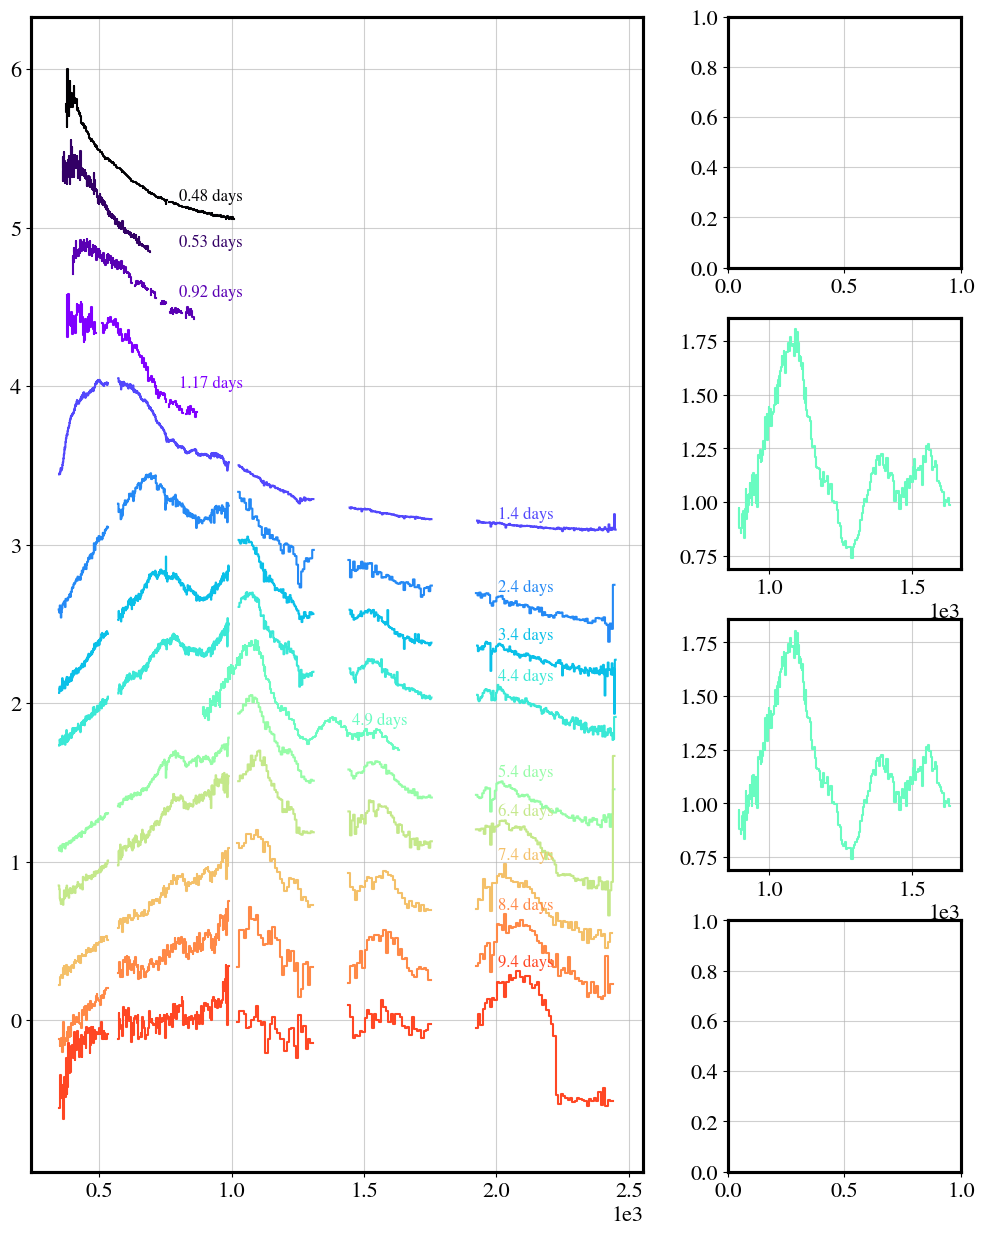

In [17]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]

fig,ax = plt.subplot_mosaic("AB;AC;AD;AE", figsize=(12,15), gridspec_kw={'width_ratios': [10, 3.8]})
ratio_off_set = np.array([ 4.4, 3.95, 3.33, 2.98, 2.45,  1.85,  1.45,  1.1 ,  0.45,  0.1 ,
        -0.40, -0.85 , -1.25]) + 0.6
#0.3*np.arange(13)[::-1] - 0.7

#np.array([10.        ,  7.74263683,  5.9948425 ,  4.64158883,  3.59381366,
        #2.7825594 ,  2.4443469,  1.3810054,  1.29154967,  1. , 0.9, 0.6, 0.4       ])
#np.logspace(0,1,10)[::-1]
#np.array([7,6,5,3.5,2.5,1.8,1])#[0.5e-16, 0]

ax['A'].plot(wl_LDSS3/10, flux_LDSS3/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0], #convolve(flux_LDSS3, g2, fill_value=np.nan)*ratio_off_set[0]*1.4, 
             color=get_darker(0.01, rtot[0]), ds='steps', label='0.48 days')

ax['A'].text(8000/10, np.max(flux_LDSS3[(wl_LDSS3>8000) & (wl_LDSS3<22000)])/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+
                     ratio_off_set[0]+0.03, '0.48 days', color=get_darker(0.01, rtot[0]), fontsize=fontsize, rotation=rotation)
     
#ax['A'].text(1050, 5.2, 'LDSS (0.49 days)', fontsize=14, color=get_darker(0.1, r[0]))


#ax['A'].plot(wl_LDSS3b/10, convolve(flux_LDSS3b, g2, fill_value=np.nan)*ratio_off_set[0]*1.3, 
#             alpha=1, color='k')#[0, 0, 0.9])
#ax['A'].plot(wl_LDSS3r/10, convolve(flux_LDSS3r, g2, fill_value=np.nan)*ratio_off_set[0]*1.4, 
#             alpha=1, color='k') #[0, 0, 0.9])

ax['A'].plot(wl_MagE/10 , flux_MagE/np.max(flux_MagE[flux_MagE==flux_MagE])+ratio_off_set[1], #convolve(flux_MagE, g3, fill_value=np.nan)*ratio_off_set[1]*1.4 , 
             color=get_darker(0.4, rtot[0]), ds='steps', label='0.53 days')
ax['A'].text(8000/10, np.max(flux_MagE[(wl_MagE>6900) & (wl_MagE<22000)])/np.max(flux_MagE[flux_MagE==flux_MagE])+
                     ratio_off_set[1]+0.03, '0.53 days', color=get_darker(0.4, rtot[0]), fontsize=fontsize, rotation=rotation)
    #ax['A'].text(1050, 4.8, 'MagE (0.53 days)', fontsize=14, color=get_darker(0.3, r[0]))

ax['A'].plot(wav_ANU/10 , flux_ANU/np.max(flux_ANU[flux_ANU==flux_ANU])+ratio_off_set[2], 
             alpha=1, color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days')
ax['A'].text(8000/10, np.max(flux_ANU[(wav_ANU>7300) & (wav_ANU<22000)])/np.max(flux_ANU[flux_ANU==flux_ANU])+
                     ratio_off_set[2]+0.03, '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)

#ax['A'].text(1050, 4.4, 'ANU (0.93 days)', fontsize=14, color=get_darker(0.5, r[0]))

ax['A'].plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.17 days')
ax['A'].text(8000/10, np.max(f_SALT[(f_SALT==f_SALT) & (wl_SALT>7300) & (wl_SALT<22000)])/np.max(f_SALT[f_SALT==f_SALT])+
                     ratio_off_set[3]+0.03, '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax['A'].text(1050, 4.0, 'SALT (1.18 days)', fontsize=14, color=get_darker(0.8, r[0]) )

#ax['A'].plot(wl_SALT/10 , f_SALT*ratio_off_set[1]*6,#convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
#             alpha=1, color=r[0], ds='steps')

wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G102_G141_Phase+4.9d_deredz.dat' ).T
ax['A'].plot( wl/10, flux/np.max(flux[flux==flux])+1.4, color=r_HST, ds='steps', 
            label='4.9 days')
#ax['A'].text(1700, 1.7, 'HST (4.9 days)', fontsize=15, color=get_darker(0.8, r[3]))
#ax['A'].text(1700, 1.7, 'HST (4.9 days)', fontsize=15, color='k', alpha=0.2)
ax['A'].text(14550/10, np.max(flux[(wl>15000) & (wl<22000)])/np.max(flux[flux==flux])+
                     1.4+0.03, '4.9 days', color=r_HST, fontsize=fontsize, rotation=rotation)
        

ax['C'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color=r_HST, alpha=1, ds='steps' )
#ax['C'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color='k', alpha=0.2, ds='steps' )

ax['D'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color=r_HST, alpha=1, ds='steps' )
#ax['D'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color='k', alpha=0.2, ds='steps' )

#wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G141_Phase_9.4d_deredz.dat' ).T
#ax['A'].plot( (wl/10)[wl>11800], (flux/np.max(flux[flux==flux])-0.2)[wl>11800], color=r_HST2, alpha=0.8, ds='steps' )

#wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G102_G141_Phase+10.6d_deredz.dat' ).T
#ax['A'].plot( wl/10, flux*0.6, color='k', alpha=0.8 )

for i in [0,1,2,3,4,5,6,7,8]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    #mask2 = ((wl > 13100) & (wl < 14400)) 
    #flux2[mask] = np.nan; error2[mask] = np.nan
    #wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, ~mask, 20)
    #wl10, flux10, error10,_ = bin_spectrum(wl2, flux2, error2, mask, 10)
    
    if (i == 0) or (i==2) or (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
     
        
    if (i==4) or (i==1) or (i==5): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 100)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
    if (i>=6): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 150)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20100) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        #wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, ~mask2, 5)
        #ax['A'].plot(wl50/10, flux50*ratio_off_set[i+3], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
        #         color=r[i] , alpha=0.1, ds='steps')
        
    #ax['A'].plot(wl10/10, flux10*ratio_off_set[i+3], 
    #         color=[(i)/8, 0, 0.4]
    #             , alpha=0.1)



#p0 = np.array([6.23037901e+03, 1.71248085e-30])
p0 = np.array([5.87769115e+03, 1.78869715e-30])
def bb(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


#ax['A'].plot(wl_SALT/10, bb(wl_SALT*1e-10, *p0)*ratio_off_set[1]*6 )    
#ax['C'].plot(wl_SALT/10, f_SALT/ bb(wl_SALT*1e-10, *p0), alpha=1, color=get_darker(1, rtot[0]), ds='steps' )#*ratio_off_set[1]*6 )
#ax['C'].plot(wl_SALT/10, f_SALT/ bb(wl_SALT*1e-10, *p0), alpha=0.3, color='k', ds='steps')
ax['C'].plot( wl_SALT/10, f_SALT/bb(wl_SALT*1e-10, *p_SALT), 
                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )

fit_res = ["../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl", "../Kilonova/Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "../Kilonova/Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

for i in [0,1,2]: #,3,4]: 
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    p = emcee_res.params
    
    flux_fit = residual(p, wl2*1e-10)
    p['amp1'].value = 0; p['amp2'].value = 0; p['tau'].value = 0
    flux_fit_BB = residual(p, wl2*1e-10)

    #ax['A'].plot(wl2/10, flux_fit_BB*ratio_off_set[i+3], ls='-', label='Blackbody', 
     #           color=r[i]#[(i)/8, 0, 0.4]
      #           , alpha=0.3)
    

# Sr  
for i in [0,1,2,3,4]: 
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    p = emcee_res.params
    
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19300))
    
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 75)
    #flux2[mask] = np.nan; error2[mask] = np.nan
    
    flux_fit = residual(p, wl2*1e-10)
    p['amp1'].value = 0; p['amp2'].value = 0; p['tau'].value = 0
    flux_fit_BB = residual(p, wl2*1e-10)

    
    ax['C'].plot(wl2/10, flux2/flux_fit_BB, ls='-', label='Blackbody', 
                color=r[i], ds='steps'#[(i)/8, 0, 0.4]
                 , alpha=0.8)
    #ax['C'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=1)
    
    #ax['D'].plot(wl2/10, flux2/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=0.8)
    #ax['D'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=0.5)    
    
    
# 2.1 mum feature    
for i in [0,2,3,4,5]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19200)) | ((wl > 19700) & (wl < 20050))
    
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 100)
    #flux2[mask] = np.nan; error2[mask] = np.nan

    
    if i<=4:
        pickle_in = open(fit_res[i],"rb")
        emcee_res = pickle.load(pickle_in)
        p = emcee_res.params
        flux_fit = residual(p, wl2*1e-10)
        p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
        flux_fit_BB = residual(p, wl2*1e-10)
        
        #ax['D'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')
        ax['E'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')

    #if i==5:
    #    ax['D'].plot(wl2/10, flux2/bb(wl2*1e-10,p['T'].value, 0.7*p['N'].value), ls='-', color=r[5], alpha=0.8, ds='steps')    
    #if i==6:
    #    ax['D'].plot(wl2/10, flux2/bb(wl2*1e-10,t7, p['N'].value), ls='-', color=r[6], alpha=0.8)    

# 760 nm P Cygni
for i in [0,3,4]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2; mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 7500) & (wl < 7600)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19200)) | ((wl > 19700) & (wl < 20100))
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 100)
    
    if i>=2:
        pickle_in = open(fit_res[i],"rb"); 
        emcee_res = pickle.load(pickle_in)
        p = emcee_res.params

        flux_fit = residual(p, wl2*1e-10)
        p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
        flux_fit_BB = residual(p, wl2*1e-10)
        
        ax['B'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')

    #if i==0:
    #    pickle_in = open(fit_res[i],"rb"); 
    #    emcee_res = pickle.load(pickle_in)
    #    p = emcee_res.params

    #    flux_fit = residual(p, wl2*1e-10)
    #    p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
    #    flux_fit_BB = residual(p, wl2*1e-10)
        
        #ax['B'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.7, ds='steps')
        
        
    #if i==5:
        #ax['A'].plot(wl2/10, bb(wl2*1e-10, 2800, 5e-29), ls='-', color=r[i], alpha=0.7) 
    #    ax['B'].plot(wl2/10, flux2/bb(wl2*1e-10,2800, 5e-29), ls='-', color=r[i], alpha=0.7) 
        
    #ax['B'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=1)
    
    
#velocity scale    
#ax['B'].text(760*0.925, 0.84, '0.1 $c$', fontsize=14)
#ax['B'].errorbar([760, 760*0.9], [0.83, 0.83], yerr=[0.005, 0.005], color='k')

#ax['C'].text(1050*0.905, 0.59, '0.1 $c$', fontsize=14)
#ax['C'].errorbar([1050, 1050*0.9], [0.55, 0.55], yerr=[0.02, 0.02], color='k')

ax['D'].text(1401.8*0.935, 0.75, '$0.1c$', fontsize=14, color='grey')
ax['D'].errorbar([1401.8, 1401.8*0.905], [0.73, 0.73], yerr=[0.01, 0.01], color='grey')


ax['E'].text(2050*0.915, 0.82, '$0.1c$', fontsize=14, color='grey')
ax['E'].errorbar([2050, 2050*0.9], [0.77, 0.77], yerr=[0.02, 0.02], color='grey')

#ax['B'].text(760/1.1, 0.83, '-0.1 $c$', fontsize=14, rotation=90)
#ax['B'].text(760/1.2, 0.83, '-0.2 $c$', fontsize=14, rotation=90)

plt.subplots_adjust(wspace=0.05, hspace=0.28)


nunits = 1 #mum
#limits
ax['A'].set_ylim(-0.25,6.0); 
ax['A'].set_xlim(350, 2240)
ax['D'].set_xlim(1220, 1460), ax['D'].set_ylim(0.7, 1.38)
ax['E'].set_xlim(1420/nunits, 2300/nunits), ax['E'].set_ylim(0.7, 2.2),

ax['B'].set_xlim(573/nunits, 840/nunits), ax['B'].set_ylim(0.82, 1.18)   
ax['C'].set_xlim(630/nunits, 1220/nunits), ax['C'].set_ylim(0.51, 1.85), #ax['C'].set_ylim(0.5, 1.85), 

#text
for axis,text in zip([ax['B'], ax['C'], ax['D'], ax['E']], 
        [r'760 nm P Cygni; Y II', r'1 $\mu$m P Cygni; Sr II', r'1.4 $\mu$m P Cygni; La III', r'NIR features']):    
    x1 = axis.get_xlim()[0] + 0.03*(axis.get_xlim()[1]-axis.get_xlim()[0])
    y1 = axis.get_ylim()[1] - 0.1*(axis.get_ylim()[1]-axis.get_ylim()[0])
    axis.axhline(1, ls='--', color='k'), 
    axis.text(x1/nunits, y1  , text, fontsize=16)

#ax['D'].set_xlim(1400, 2300), ax['D'].set_ylim(0.7, 2.2), ax['D'].set_xticks([1600, 2000])
#ax['D'].axhline(1, ls='--', color='k'), ax['D'].text(1440, 2.05, r'NIR features', fontsize=16)


#Labels
ax['A'].set_ylabel(r'$F_{\lambda}$  (normalised and offset)')
ax['B'].set_title(r'Feature zoom-in', fontsize=18)
ax['B'].yaxis.set_label_position("right"), ax['B'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['C'].yaxis.set_label_position("right"), ax['C'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['D'].yaxis.set_label_position("right"), ax['D'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['E'].yaxis.set_label_position("right"), ax['E'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['A'].set_xlabel(r'Wavelength (nm)')
ax['B'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2),
ax['C'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)
ax['D'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)
ax['E'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)

#Ticks
ax['B'].yaxis.tick_right(), ax['C'].yaxis.tick_right(), ax['D'].yaxis.tick_right(), ax['E'].yaxis.tick_right()
ax['B'].tick_params(axis='both', which='major', labelsize=15)
ax['C'].tick_params(axis='both', which='major', labelsize=15)
ax['D'].tick_params(axis='both', which='major', labelsize=15)

ax['A'].set_yscale('linear'), ax['A'].set_xscale('linear'), 
ax['A'].grid(); ax['B'].grid(); ax['C'].grid(); ax['D'].grid(); ax['E'].grid(); 
ax['A'].ticklabel_format(axis='x', style='plain')
ax['C'].ticklabel_format(axis='x', style='plain')
ax['D'].ticklabel_format(axis='x', style='plain')

#velocity-scale
#    axB_v = ax['B'].twiny()
#    axB_v.set_xlim( np.log10(ax['B'].get_xlim()) )
    #axB_v.set_xscale('log')
#    axB_v.set_xticks([np.log10(760*(i+1)) for i in [-0.2, -0.1, 0, 0.1]])
#    axB_v.set_xticklabels(['-0.2c', '-0.1c', '0', '0.1c'], fontsize=14)
#    axB_v.grid()
#    axB_v.set_xlabel('Velocity offset', fontsize=16)

#    axB_v = ax['C'].twiny()
#    axB_v.set_xlim( np.log10(ax['C'].get_xlim()) )
    #axB_v.set_xscale('log')
#    axB_v.set_xticks([np.log10(1045*(i+1)) for i in [-0.3, -0.2, -0.1, 0, 0.1]])
#    axB_v.set_xticklabels(['-0.3c', '-0.2c', '-0.1c', '0', '0.1c'], fontsize=14)
#    axB_v.grid()
#    axB_v.set_xlabel('Velocity offset', fontsize=16)

plt.rcParams['legend.title_fontsize'] = 16
#ax['A'].legend(frameon=False, fontsize=15, title='X-shooter')
g = ax['A']
# Here is where the magic happens
h_i,l = g.get_legend_handles_labels()

g.legend(['LDSS + MagE'] + [h_i[0]]+[h_i[1]] + ['ANU'] + [h_i[2]] + ['SALT'] + [h_i[3]] + 
         ['HST'] + [h_i[4]] + 
         ['']*1 + ['X-shooter'] + h_i[5:], 
         [''] + [l[0]] + [l[1]] + [''] + [l[2]] + [''] + [l[3]] + 
         [''] + [l[4]] + 
         ['']*1 + [' '] + l[5:],
           handler_map={str: LegendTitle({'fontsize': 15})},
          loc = "upper right",#bbox_to_anchor=(0.5, 0.7), 
         ncol=2, fontsize=14, frameon=True
        )

#ax['A'].yaxis.set_tick_params(which = 'major', direction = 'out', width = 2.5, length = 10, zorder = 1, right = False)
#ax['A'].yaxis.set_tick_params(which = 'minor', direction = 'out', width = 1.5, length = 6, zorder = 1, right = False)
ax['A'].set_yticks([]);

#log
import matplotlib.ticker as mticker
x_ticks_bcd = [[600, 700] , [700, 750, 800, 900, 1000, 1100, 1200], 
                     [1420, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]]
x_tick_labels_bcd = [['', ''] , ['', '', '', '','', '', ''], 
                     ['', '','1600', '', '', '','2000', '','']]
#x_tick_labels_bcd = [['600', '700'] , ['', '750', '', '900','', '1100', ''], 
#                     ['', '1300', '', '1600', '', '2000', '']]

for axis, ticks, labels in zip([ax['B'], ax['C'], ax['E']], x_ticks_bcd, x_tick_labels_bcd):
    axis.set_xscale('log'); axis.set_xticks(ticks); axis.set_xticklabels(labels)
    axis.xaxis.set_minor_formatter(mticker.NullFormatter())

beta = np.linspace(-0.999, 0.9999, 1000)
rel_doppler = np.sqrt(1-beta**2)*1/(1-beta)
from scipy.interpolate import interp1d
interp760 = interp1d(beta, 1/rel_doppler)([0.2, 0.1, 0])

#axins.set_xticks([1045*i for i in interp1])
#axins.set_xticklabels([#'', '-0.4c', 
#    '-0.5$c$', '-0.4$c$', '-0.3$c$', '-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)    

ax['B'].set_xticks([768.7*i for i in interp760])
ax['B'].set_xticklabels(['-0.2$c$', '-0.1$c$', '0'], fontsize=14)
ax['B'].set_xlabel('Velocity offset', fontsize=16)

interp1 = interp1d(beta, 1/rel_doppler)([0.4, 0.3, 0.2, 0.1, 0, -0.1])
ax['C'].set_xticks([1045*i for i in interp1])
ax['C'].set_xticklabels(['-0.4c', 
    '', '-0.2$c$', '', '0', ''], fontsize=14)



ax['C'].set_xlabel('Velocity offset', fontsize=16)
ax['B'].axvline(768.7 , color='grey', alpha=0.3, ls='--'); 
ax['C'].axvline(1045, color='grey', alpha=0.3, ls='--')
ax['D'].axvline(1401.8, color='grey', alpha=0.3, ls='--')
ax['E'].axvline(1550, color='grey', alpha=0.3, ls='--')
ax['E'].axvline(2050, color='grey', alpha=0.3, ls='--')
    
ax['B'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['C'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['D'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['E'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

Binning image by a factor: 8
Binning image by a factor: 8
Binning image by a factor: 50


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_2923/844939264.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_2923/844939264.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_2923/844939264.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_2923/844939264.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 100
Binning image by a factor: 50
Binning image by a factor: 50
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 150
Binning image by a factor: 150
Binning image by a factor: 150


/Users/asnep1/Desktop/Present/Spectral Series (AT2017gfo)/pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100


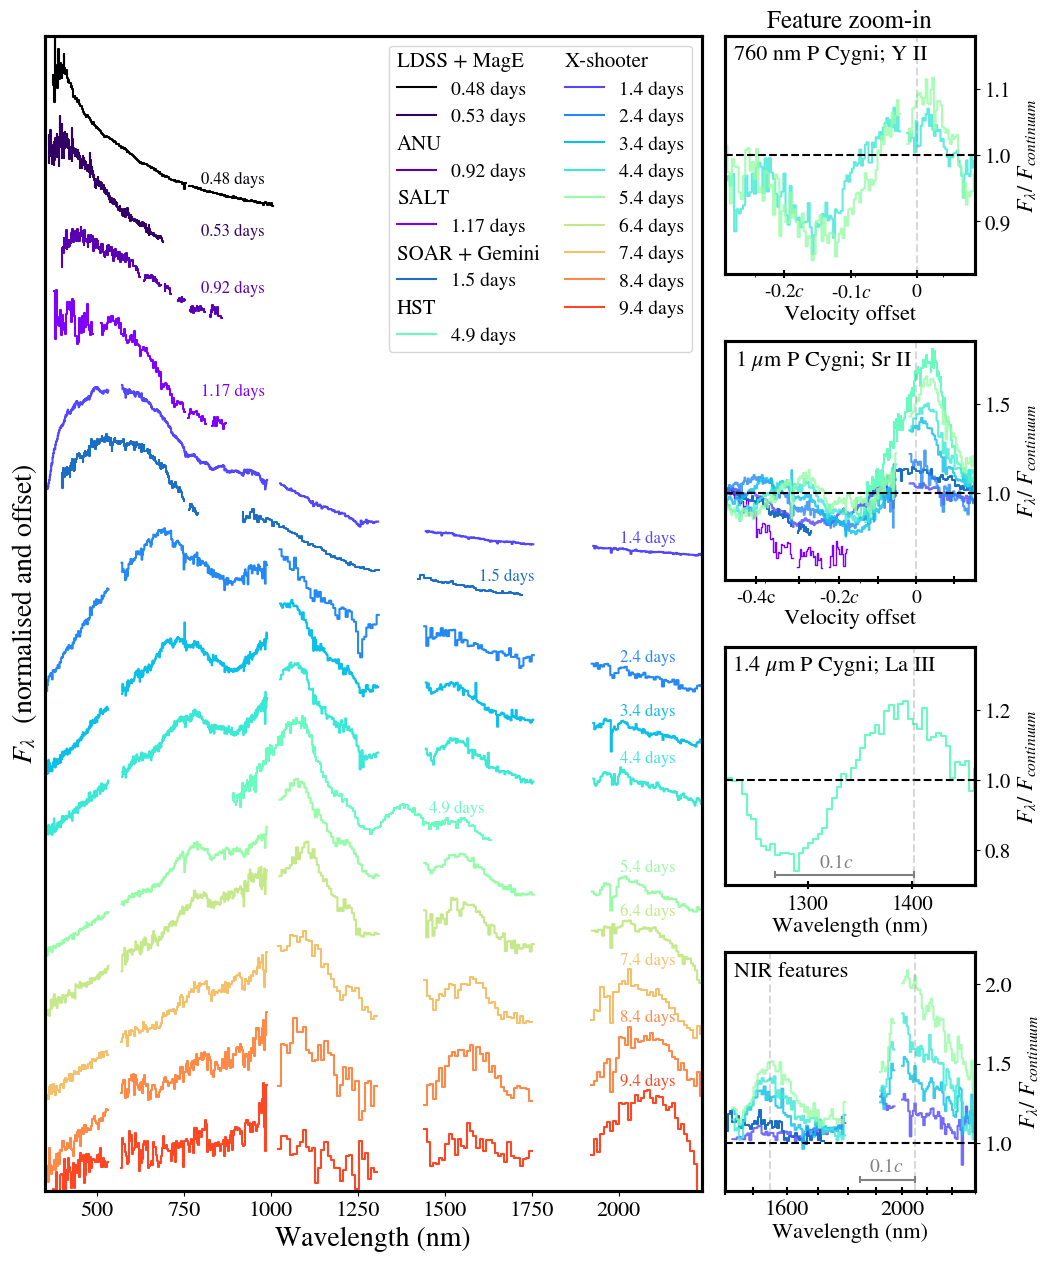

In [104]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]

fig,ax = plt.subplot_mosaic("AB;AC;AD;AE", figsize=(12,15), gridspec_kw={'width_ratios': [10, 3.8]})
ratio_off_set = np.array([ 4.4, 3.95, 3.33, 2.98, 2.45,  1.85,  1.45,  1.1 ,  0.45,  0.1 ,
        -0.40, -0.85 , -1.25]) + 0.6
#0.3*np.arange(13)[::-1] - 0.7

#np.array([10.        ,  7.74263683,  5.9948425 ,  4.64158883,  3.59381366,
        #2.7825594 ,  2.4443469,  1.3810054,  1.29154967,  1. , 0.9, 0.6, 0.4       ])
#np.logspace(0,1,10)[::-1]
#np.array([7,6,5,3.5,2.5,1.8,1])#[0.5e-16, 0]

ax['A'].plot(wl_LDSS3/10, flux_LDSS3/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0], #convolve(flux_LDSS3, g2, fill_value=np.nan)*ratio_off_set[0]*1.4, 
             color=get_darker(0.01, rtot[0]), ds='steps', label='0.48 days')

ax['A'].text(8000/10, np.max(flux_LDSS3[(wl_LDSS3>8000) & (wl_LDSS3<22000)])/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+
                     ratio_off_set[0]+0.03, '0.48 days', color=get_darker(0.01, rtot[0]), fontsize=fontsize, rotation=rotation)
     
#ax['A'].text(1050, 5.2, 'LDSS (0.49 days)', fontsize=14, color=get_darker(0.1, r[0]))


#ax['A'].plot(wl_LDSS3b/10, convolve(flux_LDSS3b, g2, fill_value=np.nan)*ratio_off_set[0]*1.3, 
#             alpha=1, color='k')#[0, 0, 0.9])
#ax['A'].plot(wl_LDSS3r/10, convolve(flux_LDSS3r, g2, fill_value=np.nan)*ratio_off_set[0]*1.4, 
#             alpha=1, color='k') #[0, 0, 0.9])

ax['A'].plot(wl_MagE/10 , flux_MagE/np.max(flux_MagE[flux_MagE==flux_MagE])+ratio_off_set[1], #convolve(flux_MagE, g3, fill_value=np.nan)*ratio_off_set[1]*1.4 , 
             color=get_darker(0.4, rtot[0]), ds='steps', label='0.53 days')
ax['A'].text(8000/10, np.max(flux_MagE[(wl_MagE>6900) & (wl_MagE<22000)])/np.max(flux_MagE[flux_MagE==flux_MagE])+
                     ratio_off_set[1]+0.03, '0.53 days', color=get_darker(0.4, rtot[0]), fontsize=fontsize, rotation=rotation)
    #ax['A'].text(1050, 4.8, 'MagE (0.53 days)', fontsize=14, color=get_darker(0.3, r[0]))

ax['A'].plot(wav_ANU/10 , flux_ANU/np.max(flux_ANU[flux_ANU==flux_ANU])+ratio_off_set[2], 
             alpha=1, color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days')
ax['A'].text(8000/10, np.max(flux_ANU[(wav_ANU>7300) & (wav_ANU<22000)])/np.max(flux_ANU[flux_ANU==flux_ANU])+
                     ratio_off_set[2]+0.03, '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)

#ax['A'].text(1050, 4.4, 'ANU (0.93 days)', fontsize=14, color=get_darker(0.5, r[0]))

ax['A'].plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.17 days')
ax['A'].text(8000/10, np.max(f_SALT[(f_SALT==f_SALT) & (wl_SALT>7300) & (wl_SALT<22000)])/np.max(f_SALT[f_SALT==f_SALT])+
                     ratio_off_set[3]+0.03, '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax['A'].text(1050, 4.0, 'SALT (1.18 days)', fontsize=14, color=get_darker(0.8, r[0]) )

#ax['A'].plot(wl_SALT/10 , f_SALT*ratio_off_set[1]*6,#convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
#             alpha=1, color=r[0], ds='steps')


## Include SOAR and Gemini data
shift = 2.75

fit_res = "../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl" 
pickle_in = open(fit_res,"rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['T'].value = p['T'].value*0.98
p['N'].value = p['N'].value*(1.05)**2
p['amp1'].value = 0
p['tau'].value = 0

path_VIS = 'nicholl_optical_spectra/gw170817_day1.5_SOAR_restframe_dered.txt'
lam, flam = np.loadtxt(path_VIS).T
exc_reg = (~((lam > 7510) & (lam < 7650)))
lam_op,flam_op,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 8)

flux_fit_op = residual(p, lam_op[1:-1]*1e-10)

ax['A'].plot(lam_op[1:-1]/10, flam_op[1:-1]/np.max(flux_fit_op)+shift, alpha=1, color=get_darker(0.8, r[1]), ds='steps', label='1.5 days')
ax['C'].plot(lam_op[1:-1]/10, flam_op[1:-1]/flux_fit_op, alpha=1, color=get_darker(0.8, r[1]), ds='steps')

path_NIR = 'CHORNOCK_NIR_final/gw170817-gemini-day1.5-dered-sca.dat'
lam, flam = np.loadtxt(path_NIR).T
exc_reg = (~((lam > 13100) & (lam < 14300))) & (lam < 17200)
lam_nir,flam_nir,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 8)
flux_fit_nir = residual(p, lam_nir[1:-1]*1e-10)

ax['A'].plot(lam_nir[1:-1]/10, flam_nir[1:-1]/np.max(flux_fit_op)+shift, alpha=1, color=get_darker(0.8, r[1]), ds='steps')

ax['C'].plot(lam_nir[1:-1]/10, flam_nir[1:-1]/flux_fit_nir, alpha=1, color=get_darker(0.8, r[1]), ds='steps')
ax['E'].plot(lam_nir[1:-1]/10, flam_nir[1:-1]/flux_fit_nir, alpha=1, color=get_darker(0.8, r[1]), ds='steps')

ax['A'].text(16000/10, 2.96, str(1.5)+' days', color=get_darker(0.8, r[1]), fontsize=fontsize, rotation=rotation)
     
#plt.plot(lam_nir, flux_fit_nir, color='darkred')



shift = -0.2
wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G102_G141_Phase+4.9d_deredz.dat' ).T
ax['A'].plot( wl/10, flux/np.max(flux[flux==flux])+1.4+shift, color=r_HST, ds='steps', 
            label='4.9 days')
#ax['A'].text(1700, 1.7, 'HST (4.9 days)', fontsize=15, color=get_darker(0.8, r[3]))
#ax['A'].text(1700, 1.7, 'HST (4.9 days)', fontsize=15, color='k', alpha=0.2)
ax['A'].text(14550/10, np.max(flux[(wl>15000) & (wl<22000)])/np.max(flux[flux==flux])+shift+
                     1.4+0.03, '4.9 days', color=r_HST, fontsize=fontsize, rotation=rotation)
        

ax['C'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color=r_HST, alpha=1, ds='steps' )
#ax['C'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color='k', alpha=0.2, ds='steps' )

ax['D'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color=r_HST, alpha=1, ds='steps' )
#ax['D'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color='k', alpha=0.2, ds='steps' )

#wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G141_Phase_9.4d_deredz.dat' ).T
#ax['A'].plot( (wl/10)[wl>11800], (flux/np.max(flux[flux==flux])-0.2)[wl>11800], color=r_HST2, alpha=0.8, ds='steps' )

#wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G102_G141_Phase+10.6d_deredz.dat' ).T
#ax['A'].plot( wl/10, flux*0.6, color='k', alpha=0.8 )

for i in [0,1,2,3,4,5,6,7,8]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    #mask2 = ((wl > 13100) & (wl < 14400)) 
    #flux2[mask] = np.nan; error2[mask] = np.nan
    #wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, ~mask, 20)
    #wl10, flux10, error10,_ = bin_spectrum(wl2, flux2, error2, mask, 10)
    
    shift = 0
    if i>0:
        shift = -0.2
    
    if (i == 0) or (i==2) or (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03+shift, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
     
        
    if (i==4) or (i==1) or (i==5): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 100)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+shift+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
    if (i>=6): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 150)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20100) & (wl50<22000)])/np.max(flux50[flux50==flux50])+shift+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        #wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, ~mask2, 5)
        #ax['A'].plot(wl50/10, flux50*ratio_off_set[i+3], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
        #         color=r[i] , alpha=0.1, ds='steps')
        
    #ax['A'].plot(wl10/10, flux10*ratio_off_set[i+3], 
    #         color=[(i)/8, 0, 0.4]
    #             , alpha=0.1)



#p0 = np.array([6.23037901e+03, 1.71248085e-30])
p0 = np.array([5.87769115e+03, 1.78869715e-30])
def bb(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


#ax['A'].plot(wl_SALT/10, bb(wl_SALT*1e-10, *p0)*ratio_off_set[1]*6 )    
#ax['C'].plot(wl_SALT/10, f_SALT/ bb(wl_SALT*1e-10, *p0), alpha=1, color=get_darker(1, rtot[0]), ds='steps' )#*ratio_off_set[1]*6 )
#ax['C'].plot(wl_SALT/10, f_SALT/ bb(wl_SALT*1e-10, *p0), alpha=0.3, color='k', ds='steps')
ax['C'].plot( wl_SALT/10, f_SALT/bb(wl_SALT*1e-10, *p_SALT), 
                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )

fit_res = ["../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl", "../Kilonova/Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "../Kilonova/Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

for i in [0,1,2]: #,3,4]: 
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    p = emcee_res.params
    
    flux_fit = residual(p, wl2*1e-10)
    p['amp1'].value = 0; p['amp2'].value = 0; p['tau'].value = 0
    flux_fit_BB = residual(p, wl2*1e-10)

    #ax['A'].plot(wl2/10, flux_fit_BB*ratio_off_set[i+3], ls='-', label='Blackbody', 
     #           color=r[i]#[(i)/8, 0, 0.4]
      #           , alpha=0.3)
    

# Sr  
for i in [0,1,2,3,4]: 
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    p = emcee_res.params
    
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19300))
    
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 75)
    #flux2[mask] = np.nan; error2[mask] = np.nan
    
    flux_fit = residual(p, wl2*1e-10)
    p['amp1'].value = 0; p['amp2'].value = 0; p['tau'].value = 0
    flux_fit_BB = residual(p, wl2*1e-10)

    
    ax['C'].plot(wl2/10, flux2/flux_fit_BB, ls='-', label='Blackbody', 
                color=r[i], ds='steps'#[(i)/8, 0, 0.4]
                 , alpha=0.8)
    #ax['C'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=1)
    
    #ax['D'].plot(wl2/10, flux2/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=0.8)
    #ax['D'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=0.5)    
    
    
# 2.1 mum feature    
for i in [0,2,3,4,5]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19200)) | ((wl > 19700) & (wl < 20050))
    
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 100)
    #flux2[mask] = np.nan; error2[mask] = np.nan

    
    if i<=4:
        pickle_in = open(fit_res[i],"rb")
        emcee_res = pickle.load(pickle_in)
        p = emcee_res.params
        flux_fit = residual(p, wl2*1e-10)
        p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
        flux_fit_BB = residual(p, wl2*1e-10)
        
        #ax['D'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')
        ax['E'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')

    #if i==5:
    #    ax['D'].plot(wl2/10, flux2/bb(wl2*1e-10,p['T'].value, 0.7*p['N'].value), ls='-', color=r[5], alpha=0.8, ds='steps')    
    #if i==6:
    #    ax['D'].plot(wl2/10, flux2/bb(wl2*1e-10,t7, p['N'].value), ls='-', color=r[6], alpha=0.8)    

# 760 nm P Cygni
for i in [0,3,4]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2; mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 7500) & (wl < 7600)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19200)) | ((wl > 19700) & (wl < 20100))
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 100)
    
    if i>=2:
        pickle_in = open(fit_res[i],"rb"); 
        emcee_res = pickle.load(pickle_in)
        p = emcee_res.params

        flux_fit = residual(p, wl2*1e-10)
        p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
        flux_fit_BB = residual(p, wl2*1e-10)
        
        ax['B'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')

    #if i==0:
    #    pickle_in = open(fit_res[i],"rb"); 
    #    emcee_res = pickle.load(pickle_in)
    #    p = emcee_res.params

    #    flux_fit = residual(p, wl2*1e-10)
    #    p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
    #    flux_fit_BB = residual(p, wl2*1e-10)
        
        #ax['B'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.7, ds='steps')
        
        
    #if i==5:
        #ax['A'].plot(wl2/10, bb(wl2*1e-10, 2800, 5e-29), ls='-', color=r[i], alpha=0.7) 
    #    ax['B'].plot(wl2/10, flux2/bb(wl2*1e-10,2800, 5e-29), ls='-', color=r[i], alpha=0.7) 
        
    #ax['B'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=1)
    
    
#velocity scale    
#ax['B'].text(760*0.925, 0.84, '0.1 $c$', fontsize=14)
#ax['B'].errorbar([760, 760*0.9], [0.83, 0.83], yerr=[0.005, 0.005], color='k')

#ax['C'].text(1050*0.905, 0.59, '0.1 $c$', fontsize=14)
#ax['C'].errorbar([1050, 1050*0.9], [0.55, 0.55], yerr=[0.02, 0.02], color='k')

ax['D'].text(1401.8*0.935, 0.75, '$0.1c$', fontsize=14, color='grey')
ax['D'].errorbar([1401.8, 1401.8*0.905], [0.73, 0.73], yerr=[0.01, 0.01], color='grey')


ax['E'].text(2050*0.915, 0.82, '$0.1c$', fontsize=14, color='grey')
ax['E'].errorbar([2050, 2050*0.9], [0.77, 0.77], yerr=[0.02, 0.02], color='grey')

#ax['B'].text(760/1.1, 0.83, '-0.1 $c$', fontsize=14, rotation=90)
#ax['B'].text(760/1.2, 0.83, '-0.2 $c$', fontsize=14, rotation=90)

plt.subplots_adjust(wspace=0.05, hspace=0.28)


nunits = 1 #mum
#limits
ax['A'].set_ylim(-0.45,6.0); 
ax['A'].set_xlim(350, 2240)
ax['D'].set_xlim(1220, 1460), ax['D'].set_ylim(0.7, 1.38)
ax['E'].set_xlim(1420/nunits, 2300/nunits), ax['E'].set_ylim(0.7, 2.2),

ax['B'].set_xlim(573/nunits, 840/nunits), ax['B'].set_ylim(0.82, 1.18)   
ax['C'].set_xlim(630/nunits, 1220/nunits), ax['C'].set_ylim(0.51, 1.85), #ax['C'].set_ylim(0.5, 1.85), 

#text
for axis,text in zip([ax['B'], ax['C'], ax['D'], ax['E']], 
        [r'760 nm P Cygni; Y II', r'1 $\mu$m P Cygni; Sr II', r'1.4 $\mu$m P Cygni; La III', r'NIR features']):    
    x1 = axis.get_xlim()[0] + 0.03*(axis.get_xlim()[1]-axis.get_xlim()[0])
    y1 = axis.get_ylim()[1] - 0.1*(axis.get_ylim()[1]-axis.get_ylim()[0])
    axis.axhline(1, ls='--', color='k'), 
    axis.text(x1/nunits, y1  , text, fontsize=16)

#ax['D'].set_xlim(1400, 2300), ax['D'].set_ylim(0.7, 2.2), ax['D'].set_xticks([1600, 2000])
#ax['D'].axhline(1, ls='--', color='k'), ax['D'].text(1440, 2.05, r'NIR features', fontsize=16)


#Labels
ax['A'].set_ylabel(r'$F_{\lambda}$  (normalised and offset)')
ax['B'].set_title(r'Feature zoom-in', fontsize=18)
ax['B'].yaxis.set_label_position("right"), ax['B'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['C'].yaxis.set_label_position("right"), ax['C'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['D'].yaxis.set_label_position("right"), ax['D'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['E'].yaxis.set_label_position("right"), ax['E'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['A'].set_xlabel(r'Wavelength (nm)')
ax['B'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2),
ax['C'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)
ax['D'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)
ax['E'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)

#Ticks
ax['B'].yaxis.tick_right(), ax['C'].yaxis.tick_right(), ax['D'].yaxis.tick_right(), ax['E'].yaxis.tick_right()
ax['B'].tick_params(axis='both', which='major', labelsize=15)
ax['C'].tick_params(axis='both', which='major', labelsize=15)
ax['D'].tick_params(axis='both', which='major', labelsize=15)

ax['A'].set_yscale('linear'), ax['A'].set_xscale('linear'), 
ax['A'].grid(); ax['B'].grid(); ax['C'].grid(); ax['D'].grid(); ax['E'].grid(); 
ax['A'].ticklabel_format(axis='x', style='plain')
ax['C'].ticklabel_format(axis='x', style='plain')
ax['D'].ticklabel_format(axis='x', style='plain')

#velocity-scale
#    axB_v = ax['B'].twiny()
#    axB_v.set_xlim( np.log10(ax['B'].get_xlim()) )
    #axB_v.set_xscale('log')
#    axB_v.set_xticks([np.log10(760*(i+1)) for i in [-0.2, -0.1, 0, 0.1]])
#    axB_v.set_xticklabels(['-0.2c', '-0.1c', '0', '0.1c'], fontsize=14)
#    axB_v.grid()
#    axB_v.set_xlabel('Velocity offset', fontsize=16)

#    axB_v = ax['C'].twiny()
#    axB_v.set_xlim( np.log10(ax['C'].get_xlim()) )
    #axB_v.set_xscale('log')
#    axB_v.set_xticks([np.log10(1045*(i+1)) for i in [-0.3, -0.2, -0.1, 0, 0.1]])
#    axB_v.set_xticklabels(['-0.3c', '-0.2c', '-0.1c', '0', '0.1c'], fontsize=14)
#    axB_v.grid()
#    axB_v.set_xlabel('Velocity offset', fontsize=16)

plt.rcParams['legend.title_fontsize'] = 16
#ax['A'].legend(frameon=False, fontsize=15, title='X-shooter')
g = ax['A']
# Here is where the magic happens
h_i,l = g.get_legend_handles_labels()

g.legend(['LDSS + MagE'] + [h_i[0]]+[h_i[1]] + ['ANU'] + [h_i[2]] + ['SALT'] + [h_i[3]] + ['SOAR + Gemini'] + [h_i[4]] + 
         ['HST'] + [h_i[5]] + 
         #['']*1 + 
         ['X-shooter'] + h_i[6:], 
         [''] + [l[0]] + [l[1]] + [''] + [l[2]] + [''] + [l[3]] + [''] + [l[4]] +  
         [''] + [l[5]] + 
         ['']*1 #+ [' '] 
         + l[6:],
           handler_map={str: LegendTitle({'fontsize': 15})},
          loc = "upper right",#bbox_to_anchor=(0.5, 0.7), 
         ncol=2, fontsize=14, frameon=True
        )

#ax['A'].yaxis.set_tick_params(which = 'major', direction = 'out', width = 2.5, length = 10, zorder = 1, right = False)
#ax['A'].yaxis.set_tick_params(which = 'minor', direction = 'out', width = 1.5, length = 6, zorder = 1, right = False)
ax['A'].set_yticks([]);

#log
import matplotlib.ticker as mticker
x_ticks_bcd = [[600, 700] , [700, 750, 800, 900, 1000, 1100, 1200], 
                     [1420, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]]
x_tick_labels_bcd = [['', ''] , ['', '', '', '','', '', ''], 
                     ['', '','1600', '', '', '','2000', '','']]
#x_tick_labels_bcd = [['600', '700'] , ['', '750', '', '900','', '1100', ''], 
#                     ['', '1300', '', '1600', '', '2000', '']]

for axis, ticks, labels in zip([ax['B'], ax['C'], ax['E']], x_ticks_bcd, x_tick_labels_bcd):
    axis.set_xscale('log'); axis.set_xticks(ticks); axis.set_xticklabels(labels)
    axis.xaxis.set_minor_formatter(mticker.NullFormatter())

beta = np.linspace(-0.999, 0.9999, 1000)
rel_doppler = np.sqrt(1-beta**2)*1/(1-beta)
from scipy.interpolate import interp1d
interp760 = interp1d(beta, 1/rel_doppler)([0.2, 0.1, 0])

#axins.set_xticks([1045*i for i in interp1])
#axins.set_xticklabels([#'', '-0.4c', 
#    '-0.5$c$', '-0.4$c$', '-0.3$c$', '-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)    

ax['B'].set_xticks([768.7*i for i in interp760])
ax['B'].set_xticklabels(['-0.2$c$', '-0.1$c$', '0'], fontsize=14)
ax['B'].set_xlabel('Velocity offset', fontsize=16)

interp1 = interp1d(beta, 1/rel_doppler)([0.4, 0.3, 0.2, 0.1, 0, -0.1])
ax['C'].set_xticks([1045*i for i in interp1])
ax['C'].set_xticklabels(['-0.4c', 
    '', '-0.2$c$', '', '0', ''], fontsize=14)



ax['C'].set_xlabel('Velocity offset', fontsize=16)
ax['B'].axvline(768.7 , color='grey', alpha=0.3, ls='--'); 
ax['C'].axvline(1045, color='grey', alpha=0.3, ls='--')
ax['D'].axvline(1401.8, color='grey', alpha=0.3, ls='--')
ax['E'].axvline(1550, color='grey', alpha=0.3, ls='--')
ax['E'].axvline(2050, color='grey', alpha=0.3, ls='--')
    
ax['B'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['C'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['D'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['E'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_withGemini+SOAR.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

Binning image by a factor: 50
Binning image by a factor: 100


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_9749/844939264.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_9749/844939264.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_9749/844939264.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_9749/844939264.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 50
Binning image by a factor: 50
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 150
Binning image by a factor: 150
Binning image by a factor: 150


/Users/asnep1/Desktop/Present/Spectral Series (AT2017gfo)/pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 75
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100


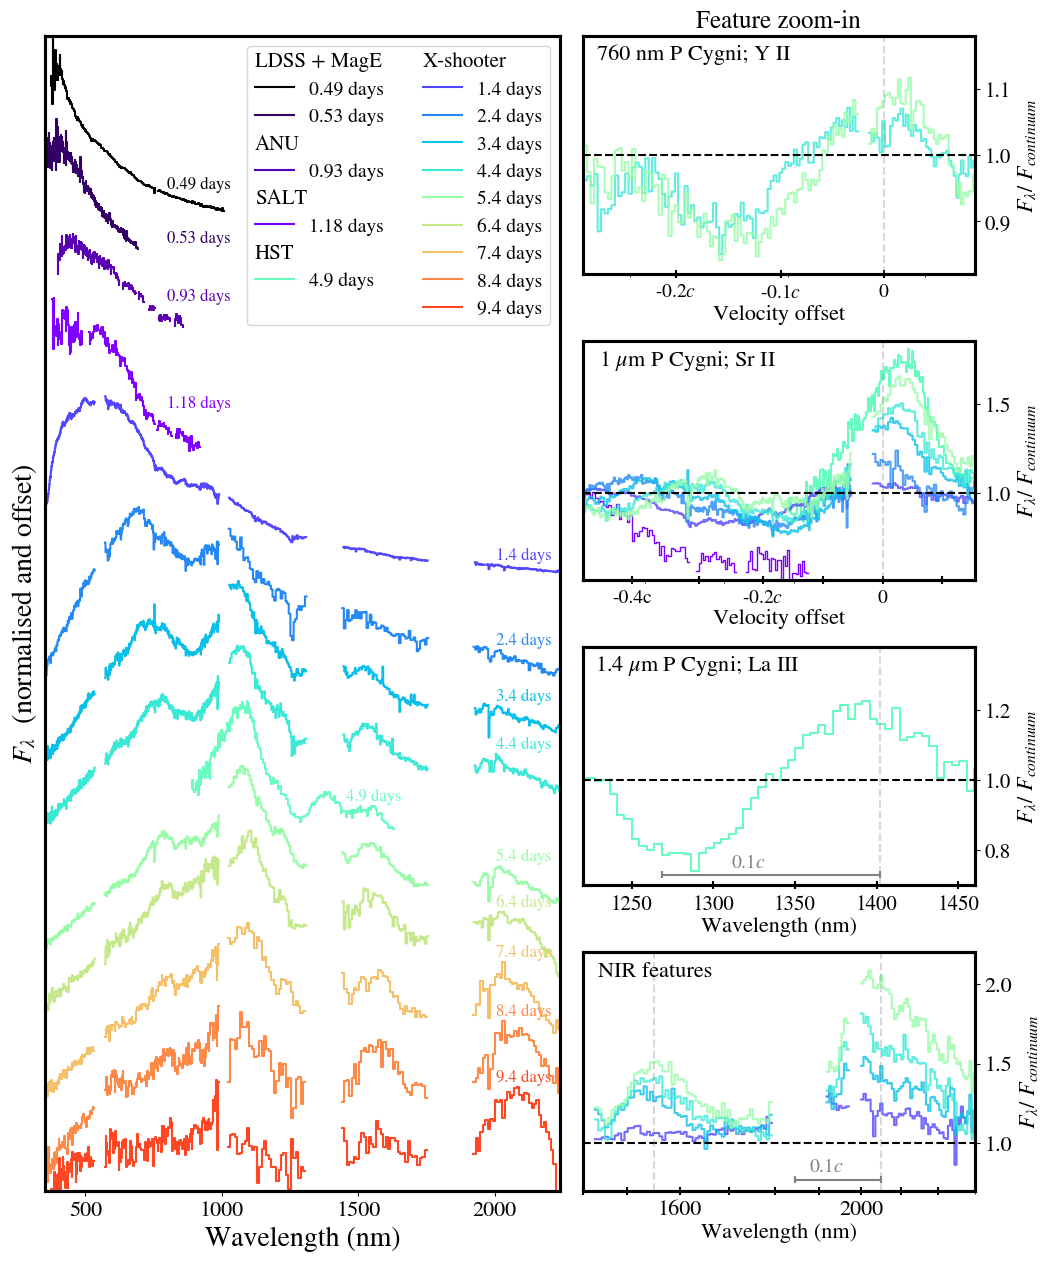

In [ ]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]

fig,ax = plt.subplot_mosaic("AB;AC;AD;AE", figsize=(12,15), gridspec_kw={'width_ratios': [5, 3.8]})
ratio_off_set = np.array([ 4.4, 3.95, 3.33, 2.98, 2.45,  1.85,  1.45,  1.1 ,  0.45,  0.1 ,
        -0.40, -0.85 , -1.25]) + 0.6
#0.3*np.arange(13)[::-1] - 0.7

#np.array([10.        ,  7.74263683,  5.9948425 ,  4.64158883,  3.59381366,
        #2.7825594 ,  2.4443469,  1.3810054,  1.29154967,  1. , 0.9, 0.6, 0.4       ])
#np.logspace(0,1,10)[::-1]
#np.array([7,6,5,3.5,2.5,1.8,1])#[0.5e-16, 0]

ax['A'].plot(wl_LDSS3/10, flux_LDSS3/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0], #convolve(flux_LDSS3, g2, fill_value=np.nan)*ratio_off_set[0]*1.4, 
             color=get_darker(0.01, rtot[0]), ds='steps', label='0.49 days')

ax['A'].text(8000/10, np.max(flux_LDSS3[(wl_LDSS3>8000) & (wl_LDSS3<22000)])/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+
                     ratio_off_set[0]+0.03, '0.49 days', color=get_darker(0.01, rtot[0]), fontsize=fontsize, rotation=rotation)
     
#ax['A'].text(1050, 5.2, 'LDSS (0.49 days)', fontsize=14, color=get_darker(0.1, r[0]))


#ax['A'].plot(wl_LDSS3b/10, convolve(flux_LDSS3b, g2, fill_value=np.nan)*ratio_off_set[0]*1.3, 
#             alpha=1, color='k')#[0, 0, 0.9])
#ax['A'].plot(wl_LDSS3r/10, convolve(flux_LDSS3r, g2, fill_value=np.nan)*ratio_off_set[0]*1.4, 
#             alpha=1, color='k') #[0, 0, 0.9])

ax['A'].plot(wl_MagE/10 , flux_MagE/np.max(flux_MagE[flux_MagE==flux_MagE])+ratio_off_set[1], #convolve(flux_MagE, g3, fill_value=np.nan)*ratio_off_set[1]*1.4 , 
             color=get_darker(0.4, rtot[0]), ds='steps', label='0.53 days')
ax['A'].text(8000/10, np.max(flux_MagE[(wl_MagE>6900) & (wl_MagE<22000)])/np.max(flux_MagE[flux_MagE==flux_MagE])+
                     ratio_off_set[1]+0.03, '0.53 days', color=get_darker(0.4, rtot[0]), fontsize=fontsize, rotation=rotation)
    #ax['A'].text(1050, 4.8, 'MagE (0.53 days)', fontsize=14, color=get_darker(0.3, r[0]))

ax['A'].plot(wav_ANU/10 , flux_ANU/np.max(flux_ANU[flux_ANU==flux_ANU])+ratio_off_set[2], 
             alpha=1, color=get_darker(0.7, rtot[0]), ds='steps', label='0.93 days')
ax['A'].text(8000/10, np.max(flux_ANU[(wav_ANU>7300) & (wav_ANU<22000)])/np.max(flux_ANU[flux_ANU==flux_ANU])+
                     ratio_off_set[2]+0.03, '0.93 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)

#ax['A'].text(1050, 4.4, 'ANU (0.93 days)', fontsize=14, color=get_darker(0.5, r[0]))

ax['A'].plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.18 days')
ax['A'].text(8000/10, np.max(f_SALT[(f_SALT==f_SALT) & (wl_SALT>7300) & (wl_SALT<22000)])/np.max(f_SALT[f_SALT==f_SALT])+
                     ratio_off_set[3]+0.03, '1.18 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax['A'].text(1050, 4.0, 'SALT (1.18 days)', fontsize=14, color=get_darker(0.8, r[0]) )

#ax['A'].plot(wl_SALT/10 , f_SALT*ratio_off_set[1]*6,#convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
#             alpha=1, color=r[0], ds='steps')

wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G102_G141_Phase+4.9d_deredz.dat' ).T
ax['A'].plot( wl/10, flux/np.max(flux[flux==flux])+1.4, color=r_HST, ds='steps', 
            label='4.9 days')
#ax['A'].text(1700, 1.7, 'HST (4.9 days)', fontsize=15, color=get_darker(0.8, r[3]))
#ax['A'].text(1700, 1.7, 'HST (4.9 days)', fontsize=15, color='k', alpha=0.2)
ax['A'].text(14550/10, np.max(flux[(wl>15000) & (wl<22000)])/np.max(flux[flux==flux])+
                     1.4+0.03, '4.9 days', color=r_HST, fontsize=fontsize, rotation=rotation)
        

ax['C'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color=r_HST, alpha=1, ds='steps' )
#ax['C'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color='k', alpha=0.2, ds='steps' )

ax['D'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color=r_HST, alpha=1, ds='steps' )
#ax['D'].plot( wl/10, flux/(N_interp*temp(wl*1e-10,T_interp)), color='k', alpha=0.2, ds='steps' )

#wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G141_Phase_9.4d_deredz.dat' ).T
#ax['A'].plot( (wl/10)[wl>11800], (flux/np.max(flux[flux==flux])-0.2)[wl>11800], color=r_HST2, alpha=0.8, ds='steps' )

#wl, flux = np.loadtxt( 'AT2017gfo_ENGRAVE_v1.0_HST_G102_G141_Phase+10.6d_deredz.dat' ).T
#ax['A'].plot( wl/10, flux*0.6, color='k', alpha=0.8 )

for i in [0,1,2,3,4,5,6,7,8]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    #mask2 = ((wl > 13100) & (wl < 14400)) 
    #flux2[mask] = np.nan; error2[mask] = np.nan
    #wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, ~mask, 20)
    #wl10, flux10, error10,_ = bin_spectrum(wl2, flux2, error2, mask, 10)
    
    if (i == 0) or (i==2) or (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
     
        
    if (i==4) or (i==1) or (i==5): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 100)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
    if (i>=6): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 150)

        ax['A'].plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days')
        
        ax['A'].text(20050/10, np.max(flux50[(wl50>20100) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
                     ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        #wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, ~mask2, 5)
        #ax['A'].plot(wl50/10, flux50*ratio_off_set[i+3], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
        #         color=r[i] , alpha=0.1, ds='steps')
        
    #ax['A'].plot(wl10/10, flux10*ratio_off_set[i+3], 
    #         color=[(i)/8, 0, 0.4]
    #             , alpha=0.1)



#p0 = np.array([6.23037901e+03, 1.71248085e-30])
p0 = np.array([5.87769115e+03, 1.78869715e-30])
def bb(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


#ax['A'].plot(wl_SALT/10, bb(wl_SALT*1e-10, *p0)*ratio_off_set[1]*6 )    
#ax['C'].plot(wl_SALT/10, f_SALT/ bb(wl_SALT*1e-10, *p0), alpha=1, color=get_darker(1, rtot[0]), ds='steps' )#*ratio_off_set[1]*6 )
#ax['C'].plot(wl_SALT/10, f_SALT/ bb(wl_SALT*1e-10, *p0), alpha=0.3, color='k', ds='steps')
ax['C'].plot( wl_SALT/10, f_SALT/bb(wl_SALT*1e-10, *p_SALT), 
                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )

fit_res = ["../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl", "../Kilonova/Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "../Kilonova/Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

for i in [0,1,2]: #,3,4]: 
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    p = emcee_res.params
    
    flux_fit = residual(p, wl2*1e-10)
    p['amp1'].value = 0; p['amp2'].value = 0; p['tau'].value = 0
    flux_fit_BB = residual(p, wl2*1e-10)

    #ax['A'].plot(wl2/10, flux_fit_BB*ratio_off_set[i+3], ls='-', label='Blackbody', 
     #           color=r[i]#[(i)/8, 0, 0.4]
      #           , alpha=0.3)
    

# Sr  
for i in [0,1,2,3,4]: 
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    p = emcee_res.params
    
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19300))
    
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 75)
    #flux2[mask] = np.nan; error2[mask] = np.nan
    
    flux_fit = residual(p, wl2*1e-10)
    p['amp1'].value = 0; p['amp2'].value = 0; p['tau'].value = 0
    flux_fit_BB = residual(p, wl2*1e-10)

    
    ax['C'].plot(wl2/10, flux2/flux_fit_BB, ls='-', label='Blackbody', 
                color=r[i], ds='steps'#[(i)/8, 0, 0.4]
                 , alpha=0.8)
    #ax['C'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=1)
    
    #ax['D'].plot(wl2/10, flux2/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=0.8)
    #ax['D'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=0.5)    
    
    
# 2.1 mum feature    
for i in [0,2,3,4,5]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19200)) | ((wl > 19700) & (wl < 20050))
    
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 100)
    #flux2[mask] = np.nan; error2[mask] = np.nan

    
    if i<=4:
        pickle_in = open(fit_res[i],"rb")
        emcee_res = pickle.load(pickle_in)
        p = emcee_res.params
        flux_fit = residual(p, wl2*1e-10)
        p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
        flux_fit_BB = residual(p, wl2*1e-10)
        
        #ax['D'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')
        ax['E'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')

    #if i==5:
    #    ax['D'].plot(wl2/10, flux2/bb(wl2*1e-10,p['T'].value, 0.7*p['N'].value), ls='-', color=r[5], alpha=0.8, ds='steps')    
    #if i==6:
    #    ax['D'].plot(wl2/10, flux2/bb(wl2*1e-10,t7, p['N'].value), ls='-', color=r[6], alpha=0.8)    

# 760 nm P Cygni
for i in [0,3,4]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2; mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9900) & (wl < 10300)) | ((wl > 13100) & (wl < 14400)) | ((wl > 7500) & (wl < 7600)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17950) & (wl < 19200)) | ((wl > 19700) & (wl < 20100))
    wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, mask, 100)
    
    if i>=2:
        pickle_in = open(fit_res[i],"rb"); 
        emcee_res = pickle.load(pickle_in)
        p = emcee_res.params

        flux_fit = residual(p, wl2*1e-10)
        p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
        flux_fit_BB = residual(p, wl2*1e-10)
        
        ax['B'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.8, ds='steps')

    #if i==0:
    #    pickle_in = open(fit_res[i],"rb"); 
    #    emcee_res = pickle.load(pickle_in)
    #    p = emcee_res.params

    #    flux_fit = residual(p, wl2*1e-10)
    #    p['amp1'].value = 0; p['amp2'].value = 0; #p['tau'].value = 0
    #    flux_fit_BB = residual(p, wl2*1e-10)
        
        #ax['B'].plot(wl2/10, flux2/flux_fit_BB, ls='-', color=r[i], alpha=0.7, ds='steps')
        
        
    #if i==5:
        #ax['A'].plot(wl2/10, bb(wl2*1e-10, 2800, 5e-29), ls='-', color=r[i], alpha=0.7) 
    #    ax['B'].plot(wl2/10, flux2/bb(wl2*1e-10,2800, 5e-29), ls='-', color=r[i], alpha=0.7) 
        
    #ax['B'].plot(wl2/10, flux_fit/flux_fit_BB, ls='-', label='Blackbody', 
    #            color=[(i)/8, 0, 0.4], alpha=1)
    
    
#velocity scale    
#ax['B'].text(760*0.925, 0.84, '0.1 $c$', fontsize=14)
#ax['B'].errorbar([760, 760*0.9], [0.83, 0.83], yerr=[0.005, 0.005], color='k')

#ax['C'].text(1050*0.905, 0.59, '0.1 $c$', fontsize=14)
#ax['C'].errorbar([1050, 1050*0.9], [0.55, 0.55], yerr=[0.02, 0.02], color='k')

ax['D'].text(1401.8*0.935, 0.75, '$0.1c$', fontsize=14, color='grey')
ax['D'].errorbar([1401.8, 1401.8*0.905], [0.73, 0.73], yerr=[0.01, 0.01], color='grey')


ax['E'].text(2050*0.915, 0.82, '$0.1c$', fontsize=14, color='grey')
ax['E'].errorbar([2050, 2050*0.9], [0.77, 0.77], yerr=[0.02, 0.02], color='grey')

#ax['B'].text(760/1.1, 0.83, '-0.1 $c$', fontsize=14, rotation=90)
#ax['B'].text(760/1.2, 0.83, '-0.2 $c$', fontsize=14, rotation=90)

plt.subplots_adjust(wspace=0.05, hspace=0.28)


nunits = 1 #mum
#limits
ax['A'].set_ylim(-0.25,6.0); 
ax['A'].set_xlim(350, 2240)
ax['D'].set_xlim(1220, 1460), ax['D'].set_ylim(0.7, 1.38)
ax['E'].set_xlim(1420/nunits, 2300/nunits), ax['E'].set_ylim(0.7, 2.2),

ax['B'].set_xlim(573/nunits, 840/nunits), ax['B'].set_ylim(0.82, 1.18)   
ax['C'].set_xlim(630/nunits, 1220/nunits), ax['C'].set_ylim(0.51, 1.85), #ax['C'].set_ylim(0.5, 1.85), 

#text
for axis,text in zip([ax['B'], ax['C'], ax['D'], ax['E']], 
        [r'760 nm P Cygni; Y II', r'1 $\mu$m P Cygni; Sr II', r'1.4 $\mu$m P Cygni; La III', r'NIR features']):    
    x1 = axis.get_xlim()[0] + 0.03*(axis.get_xlim()[1]-axis.get_xlim()[0])
    y1 = axis.get_ylim()[1] - 0.1*(axis.get_ylim()[1]-axis.get_ylim()[0])
    axis.axhline(1, ls='--', color='k'), 
    axis.text(x1/nunits, y1  , text, fontsize=16)

#ax['D'].set_xlim(1400, 2300), ax['D'].set_ylim(0.7, 2.2), ax['D'].set_xticks([1600, 2000])
#ax['D'].axhline(1, ls='--', color='k'), ax['D'].text(1440, 2.05, r'NIR features', fontsize=16)


#Labels
ax['A'].set_ylabel(r'$F_{\lambda}$  (normalised and offset)')
ax['B'].set_title(r'Feature zoom-in', fontsize=18)
ax['B'].yaxis.set_label_position("right"), ax['B'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['C'].yaxis.set_label_position("right"), ax['C'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['D'].yaxis.set_label_position("right"), ax['D'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['E'].yaxis.set_label_position("right"), ax['E'].set_ylabel(r'$F_{\lambda} $/$ F_{continuum}$', fontsize=16)
ax['A'].set_xlabel(r'Wavelength (nm)')
ax['B'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2),
ax['C'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)
ax['D'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)
ax['E'].set_xlabel(r'Wavelength (nm)', fontsize=16, labelpad=2)

#Ticks
ax['B'].yaxis.tick_right(), ax['C'].yaxis.tick_right(), ax['D'].yaxis.tick_right(), ax['E'].yaxis.tick_right()
ax['B'].tick_params(axis='both', which='major', labelsize=15)
ax['C'].tick_params(axis='both', which='major', labelsize=15)
ax['D'].tick_params(axis='both', which='major', labelsize=15)

ax['A'].set_yscale('linear'), ax['A'].set_xscale('linear'), 
ax['A'].grid(); ax['B'].grid(); ax['C'].grid(); ax['D'].grid(); ax['E'].grid(); 
ax['A'].ticklabel_format(axis='x', style='plain')
ax['C'].ticklabel_format(axis='x', style='plain')
ax['D'].ticklabel_format(axis='x', style='plain')

#velocity-scale
#    axB_v = ax['B'].twiny()
#    axB_v.set_xlim( np.log10(ax['B'].get_xlim()) )
    #axB_v.set_xscale('log')
#    axB_v.set_xticks([np.log10(760*(i+1)) for i in [-0.2, -0.1, 0, 0.1]])
#    axB_v.set_xticklabels(['-0.2c', '-0.1c', '0', '0.1c'], fontsize=14)
#    axB_v.grid()
#    axB_v.set_xlabel('Velocity offset', fontsize=16)

#    axB_v = ax['C'].twiny()
#    axB_v.set_xlim( np.log10(ax['C'].get_xlim()) )
    #axB_v.set_xscale('log')
#    axB_v.set_xticks([np.log10(1045*(i+1)) for i in [-0.3, -0.2, -0.1, 0, 0.1]])
#    axB_v.set_xticklabels(['-0.3c', '-0.2c', '-0.1c', '0', '0.1c'], fontsize=14)
#    axB_v.grid()
#    axB_v.set_xlabel('Velocity offset', fontsize=16)

plt.rcParams['legend.title_fontsize'] = 16
#ax['A'].legend(frameon=False, fontsize=15, title='X-shooter')
g = ax['A']
# Here is where the magic happens
h_i,l = g.get_legend_handles_labels()

g.legend(['LDSS + MagE'] + [h_i[0]]+[h_i[1]] + ['ANU'] + [h_i[2]] + ['SALT'] + [h_i[3]] + 
         ['HST'] + [h_i[4]] + 
         ['']*1 + ['X-shooter'] + h_i[5:], 
         [''] + [l[0]] + [l[1]] + [''] + [l[2]] + [''] + [l[3]] + 
         [''] + [l[4]] + 
         ['']*1 + [' '] + l[5:],
           handler_map={str: LegendTitle({'fontsize': 15})},
          loc = "upper right",#bbox_to_anchor=(0.5, 0.7), 
         ncol=2, fontsize=14, frameon=True
        )

#ax['A'].yaxis.set_tick_params(which = 'major', direction = 'out', width = 2.5, length = 10, zorder = 1, right = False)
#ax['A'].yaxis.set_tick_params(which = 'minor', direction = 'out', width = 1.5, length = 6, zorder = 1, right = False)
ax['A'].set_yticks([]);

#log
import matplotlib.ticker as mticker
x_ticks_bcd = [[600, 700] , [700, 750, 800, 900, 1000, 1100, 1200], 
                     [1420, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]]
x_tick_labels_bcd = [['', ''] , ['', '', '', '','', '', ''], 
                     ['', '','1600', '', '', '','2000', '','']]
#x_tick_labels_bcd = [['600', '700'] , ['', '750', '', '900','', '1100', ''], 
#                     ['', '1300', '', '1600', '', '2000', '']]

for axis, ticks, labels in zip([ax['B'], ax['C'], ax['E']], x_ticks_bcd, x_tick_labels_bcd):
    axis.set_xscale('log'); axis.set_xticks(ticks); axis.set_xticklabels(labels)
    axis.xaxis.set_minor_formatter(mticker.NullFormatter())

beta = np.linspace(-0.999, 0.9999, 1000)
rel_doppler = np.sqrt(1-beta**2)*1/(1-beta)
from scipy.interpolate import interp1d
interp760 = interp1d(beta, 1/rel_doppler)([0.2, 0.1, 0])

#axins.set_xticks([1045*i for i in interp1])
#axins.set_xticklabels([#'', '-0.4c', 
#    '-0.5$c$', '-0.4$c$', '-0.3$c$', '-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)    

ax['B'].set_xticks([768.7*i for i in interp760])
ax['B'].set_xticklabels(['-0.2$c$', '-0.1$c$', '0'], fontsize=14)
ax['B'].set_xlabel('Velocity offset', fontsize=16)

interp1 = interp1d(beta, 1/rel_doppler)([0.4, 0.3, 0.2, 0.1, 0, -0.1])
ax['C'].set_xticks([1045*i for i in interp1])
ax['C'].set_xticklabels(['-0.4c', 
    '', '-0.2$c$', '', '0', ''], fontsize=14)



ax['C'].set_xlabel('Velocity offset', fontsize=16)
ax['B'].axvline(768.7 , color='grey', alpha=0.3, ls='--'); 
ax['C'].axvline(1045, color='grey', alpha=0.3, ls='--')
ax['D'].axvline(1401.8, color='grey', alpha=0.3, ls='--')
ax['E'].axvline(1550, color='grey', alpha=0.3, ls='--')
ax['E'].axvline(2050, color='grey', alpha=0.3, ls='--')
    
ax['B'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['C'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['D'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)
ax['E'].xaxis.set_tick_params(which = 'major', direction = 'inout', width = 1.5, length = 6, zorder = 1, top = False)

#ax['C'].set_ylim(0.5, 1.2)
#ax['C'].set_xlim(650, 850)

#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [ ]:
0.8/0.9, (1.43/2.42)**2 

(0.888888888888889, 0.3491735537190083)

In [ ]:
0.6/0.8, (1.18/1.42)**2 

(0.7499999999999999, 0.6905375917476692)

In [ ]:
y1

1.1512

In [18]:
def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit

p_ldss_i,_ = curve_fit(temp_n, wl_LDSS3[(flux_LDSS3==flux_LDSS3) & (wl_LDSS3>4000)]*1e-10, flux_LDSS3[(flux_LDSS3==flux_LDSS3) & (wl_LDSS3>4000)], p0=[10000, 1e-29])
p_ldss,_ = curve_fit(temp_n, wl_LDSS3[(flux_LDSS3==flux_LDSS3) & (wl_LDSS3>6000)]*1e-10, flux_LDSS3[(flux_LDSS3==flux_LDSS3) & (wl_LDSS3>6000)], p0=[10000, 1e-29])

p_mage,_ = curve_fit(temp_n, wl_MagE[flux_MagE==flux_MagE]*1e-10, flux_MagE[flux_MagE==flux_MagE], p0=[10000, 1e-29])
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,p_cov = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6500) & (wl_SALT>3800)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6500) & (wl_SALT>3800)], p0=[6000, 1e-29])


p_ldss, p_mage, p_ANU, p_SALT

(array([1.44271175e+04, 1.28750294e-30]),
 array([8.75908634e+03, 4.40984043e-30]),
 array([6.23407578e+03, 9.52873533e-13]),
 array([6.40599339e+03, 2.11477575e-30]))

In [20]:
p_ldss_i

array([1.17052147e+04, 1.92323002e-30])

In [16]:
print(np.sqrt(np.diagonal(p_cov))[0])

78.3346261069881


In [18]:
np.sqrt(78.3346261069881**2+77**2)

109.842221605909

In [17]:
6400*0.012

76.8

Binning image by a factor: 6
Binning image by a factor: 6


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


name,value,standard error,relative error,initial value,min,max,vary
T,5288.55168,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.5271e-29,3.1434e-32,(0.21%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,126000.000,,,126000,-inf,inf,False
tau,0.00000000,4.75750986,(inf%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,0.01110866,0.03904019,(351.44%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.00000000,0.00724750,(inf%),0.26169986240919846,0.00000000,5.00000000,True


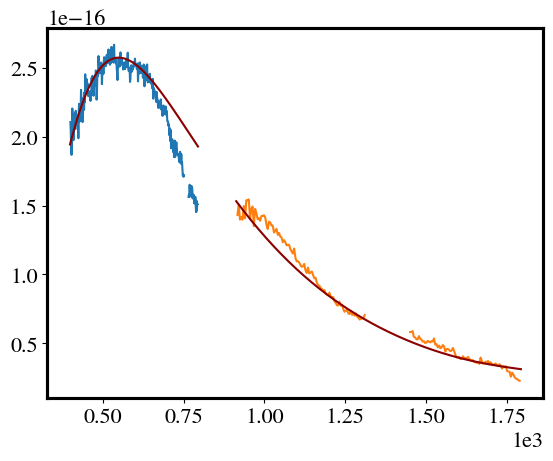

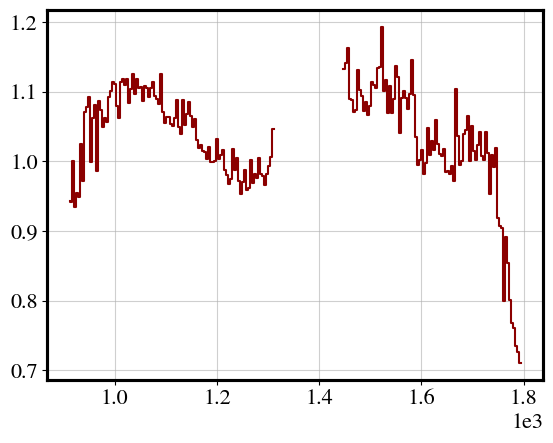

In [21]:


plt.figure()
fit_res = "../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl" 
pickle_in = open(fit_res,"rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['T'].value = p['T'].value*0.972
p['N'].value = p['N'].value*(1.07)**2
p['amp1'].value = 0
p['tau'].value = 0

path_VIS = 'nicholl_optical_spectra/gw170817_day1.5_SOAR_restframe_dered.txt'
lam, flam = np.loadtxt(path_VIS).T
exc_reg = (~((lam > 7510) & (lam < 7650)))
lam_op,flam_op,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 6)

plt.plot(lam_op[1:-1]/10, flam_op[1:-1])
flux_fit_op = residual(p, lam_op*1e-10)
plt.plot(lam_op/10, flux_fit_op, color='darkred')


path_NIR = 'CHORNOCK_NIR_final/gw170817-gemini-day1.5-dered-sca.dat'
lam, flam = np.loadtxt(path_NIR).T
exc_reg = (~((lam > 13100) & (lam < 14500)))
lam_nir,flam_nir,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 6)

plt.plot(lam_nir[1:-1]/10, flam_nir[1:-1])
flux_fit_nir = residual(p, lam_nir*1e-10)
plt.plot(lam_nir/10, flux_fit_nir, color='darkred')

wl_both = np.linspace(4000, 18000)
flux_fit_both = residual(p, wl_both*1e-10)


#plt.xlim(3800, 17500)
plt.grid()

plt.figure()
plt.plot(lam_nir/10, flam_nir/flux_fit_nir, color='darkred', ds='steps')

p

Binning image by a factor: 50
Binning image by a factor: 80


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/745145174.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

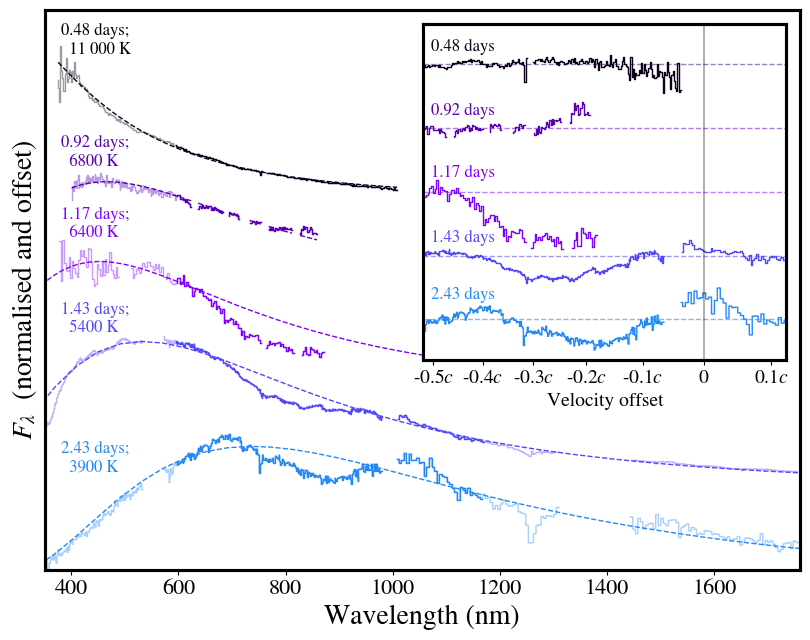

In [25]:
if_NIR = False


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.7,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(8.5,6.8) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
axins = inset_axes(ax, width='48%', height='60%', loc='upper right')
axins.set_yticks([])
#axins.set_xticks([])
#axins.set_ylim(0.5, 1.5)
plt.axhline( 1+off_sets[0], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.4, rtot[0]) )
plt.axhline( 1+off_sets[1], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.7, rtot[0]) )
plt.axhline( 1+off_sets[2], ls='--', linewidth=1, alpha=0.5, color=get_darker(1, rtot[0]))
plt.axhline( 1+off_sets[3], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.8, r[0]) )
plt.axhline( 1+off_sets[4], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.8, r[1]) )
axins.grid()


axins.text( 6000/10, 1.1+off_sets[0] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.48 days', color=get_darker(0.1, rtot[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.1+off_sets[1] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.11+off_sets[2] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.1+off_sets[3] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=get_darker(1, r[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.15+off_sets[4] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.43 days', color=get_darker(1, r[1]), fontsize=fontsize, rotation=rotation)


ratio_off_set = np.linspace(0,3.2,6)[::-1]#np.ones(10) #np.array([ 4.4, 3.95, 3.33, 2.98, 2.45,  1.85,  1.45,  1.1 ,  0.45,  0.1 ,
        #-0.40, -0.85 , -1.25]) + 0.6
#0.3*np.arange(13)[::-1] - 0.7

#np.array([10.        ,  7.74263683,  5.9948425 ,  4.64158883,  3.59381366,
        #2.7825594 ,  2.4443469,  1.3810054,  1.29154967,  1. , 0.9, 0.6, 0.4       ])
#np.logspace(0,1,10)[::-1]
#np.array([7,6,5,3.5,2.5,1.8,1])#[0.5e-16, 0]

norm = np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])
ax.plot(wl_LDSS3/10, flux_LDSS3/norm+ratio_off_set[1],
             color=get_darker(0.1, rtot[0]), ds='steps', label='0.48 days', alpha=0.4, linewidth=1)
ax.plot(wl_LDSS3[(wl_LDSS3>10450*0.57) & (wl_LDSS3<10450*1.1)]/10, flux_LDSS3[(wl_LDSS3>10450*0.57) & (wl_LDSS3<10450*1.1)]/norm+ratio_off_set[1],
             color=get_darker(0.1, rtot[0]), ds='steps', label='0.48 days', alpha=1, linewidth=1)

ax.text(3800/10, ratio_off_set[1]+0.95 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.48 days; \n  11 000 K', color=get_darker(0.01, rtot[0]), fontsize=fontsize, rotation=rotation)
ax.plot(    wl_LDSS3/10, temp_n(wl_LDSS3*1e-10, *p_ldss_i )/norm+ratio_off_set[1], 
            color=get_darker(0.1, rtot[0]), linewidth=1, ls='--' )
axins.plot( wl_LDSS3/10, flux_LDSS3/temp_n(wl_LDSS3*1e-10, *p_ldss )+off_sets[0], 
           color=get_darker(0.1, rtot[0]), linewidth=1, ls='-', ds='steps' )


#norm = np.max(flux_MagE[flux_MagE==flux_MagE])
#ax.plot(wl_MagE/10 , flux_MagE/norm+ratio_off_set[1], 
#             color=get_darker(0.4, rtot[0]), ds='steps', label='0.53 days', alpha=0.5)
#ax['A'].text(9000/10, np.max(flux_MagE[(wl_MagE>6900) & (wl_MagE<22000)])/np.max(flux_MagE[flux_MagE==flux_MagE])+
#                     ratio_off_set[1]+0.03, '0.53 days', color=get_darker(0.4, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wl_MagE/10, temp_n(wl_MagE*1e-10, *p_mage )/norm+ratio_off_set[1], 
#            color=get_darker(0.4, r[0]), linewidth=1, ls='--' )
#axins.plot( wl_MagE/10, flux_MagE/temp_n(wl_MagE*1e-10, *p_mage )+off_sets[1], 
#           color=get_darker(0.4, rtot[0]), linewidth=1, ls='-', ds='steps' )


norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.8*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days', alpha=0.4, linewidth=1)
ax.plot(wav_ANU[((wav_ANU>10450*0.57) & (wav_ANU<10450*1.1)) | (wav_ANU!=wav_ANU)]/10 , 0.8*flux_ANU[((wav_ANU>10450*0.57) & (wav_ANU<10450*1.1)) | (wav_ANU!=wav_ANU)]/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days', alpha=1, linewidth=1)


ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days; \n  6800 K', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )
axins.plot( wav_ANU/10, flux_ANU/temp_n(wav_ANU*1e-10, *p_ANU )+off_sets[1], 
           color=get_darker(0.7, rtot[0]), linewidth=1, ls='-', ds='steps' )


ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.17 days', alpha=0.4, linewidth=1)
#ax.plot(wl_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) | (f_SALT!=f_SALT)]/10 , f_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) | (f_SALT!=f_SALT)]/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
#             color=get_darker(1, rtot[0]), ds='steps', label='1.18 days', alpha=1, linewidth=1)
ax.plot(wl_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1))]/10 , f_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) ]/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.17 days', alpha=1, linewidth=1)


ax.plot(    wl_SALT/10, temp_n(wl_SALT*1e-10, *p_SALT )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=1, ls='--' )
axins.plot( wl_SALT/10, f_SALT/temp_n(wl_SALT*1e-10, *p_SALT)+off_sets[2], 
                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days; \n  6400 K', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days; \n  5400 K', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.43 days; \n  3900 K', color=r[1], fontsize=fontsize, rotation=rotation)

#pickle_in = open("../Kilonova/Data/Early_chains/SALT_21nov_params.pkl","rb") #OB1_3_peaks_100walkers
#p1 = pickle.load(pickle_in)
#p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0
#ax.plot(    wl_SALT/10, residual(p1, wl_SALT*1e-10 )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
#                color=get_darker(1, r[0]), linewidth=1, ls='--' )
#axins.plot( wl_SALT/10, f_SALT/residual(p1, wl_SALT*1e-10)+off_sets[2], 
#                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )

plt.plot()
#ax['A'].text(9000/10, np.max(f_SALT[(f_SALT==f_SALT) & (wl_SALT>7300) & (wl_SALT<22000)])/np.max(f_SALT[f_SALT==f_SALT])+
 #                    ratio_off_set[3]+0.03, '1.18 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

for i in [0,1,2]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    #mask2 = ((wl > 13100) & (wl < 14400)) 
    #flux2[mask] = np.nan; error2[mask] = np.nan
    #wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, ~mask, 20)
    #wl10, flux10, error10,_ = bin_spectrum(wl2, flux2, error2, mask, 10)
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        
        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
        if if_NIR: 
            ax.plot(wl50[wl50>10000]/10, (flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4])[wl50>10000], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
            ax.plot(wl50[(wl50>10000) & (wl50<10450*1.12)]/10, flux50[(wl50>10000) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
     
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        
        axins.plot( wl50/10, 
                 flux50/residual(p1, wl50*1e-10)+off_sets[3], 
                color=r[i], linewidth=1, ls='-', ds='steps' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0

        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        axins.plot( wl50/10, 
                 flux50/residual(p1, wl50*1e-10)+off_sets[4], 
                color=r[i], linewidth=1, ls='-', ds='steps' )
    
ax.set_xlim(350, 1760)#, 
ax.set_ylim(0.1, 3.80)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)')
#plt.yscale('log')


import matplotlib.ticker as mticker
x_ticks_bcd = [700, 750, 800, 900, 1000, 1100]
x_tick_labels_bcd = ['', '', '', '','', ''], 
#x_tick_labels_bcd = [['600', '700'] , ['', '750', '', '900','', '1100', ''], 
#                     ['', '1300', '', '1600', '', '2000', '']]

#for axis, ticks, labels in zip([ax['B'], ax['C'], ax['E']], x_ticks_bcd, x_tick_labels_bcd):
#axins.set_xscale('log'); 
#axins.set_xticks(ticks); axins.set_xticklabels(labels)
axins.xaxis.set_minor_formatter(mticker.NullFormatter())
axins.set_xlim(587, 1180)
axins.set_ylim(0.5,3)

#ax['B'].set_xticks([760*(i+1) for i in [-0.2, -0.1, 0, 0.1]])
#ax['B'].set_xticklabels(['-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)
#ax['B'].set_xlabel('Velocity offset', fontsize=16)

beta = np.linspace(-0.999, 0.9999, 1000)
rel_doppler = np.sqrt(1-beta**2)*1/(1-beta)
from scipy.interpolate import interp1d
interp1 = interp1d(beta, 1/rel_doppler)([0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1])

axins.set_xticks([1045*i for i in interp1])
axins.set_xticklabels([#'', '-0.4c', 
    '-0.5$c$', '-0.4$c$', '-0.3$c$', '-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)
axins.set_xlabel('Velocity offset', fontsize=14)

ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)')
plt.tight_layout()

axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/Sr_feature_emergence_Petri_2.png', dpi=300)

In [266]:
0.03*24*60

print( 0.99* ( (43-41)/60/24+36/24 - 14*1.5/60/24 ) )

1.4719375


In [98]:
0.07*24

1.6800000000000002

In [ ]:
12:41:04.4
        
        

Binning image by a factor: 50
Binning image by a factor: 80


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2290422681.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5123/2234170821.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect

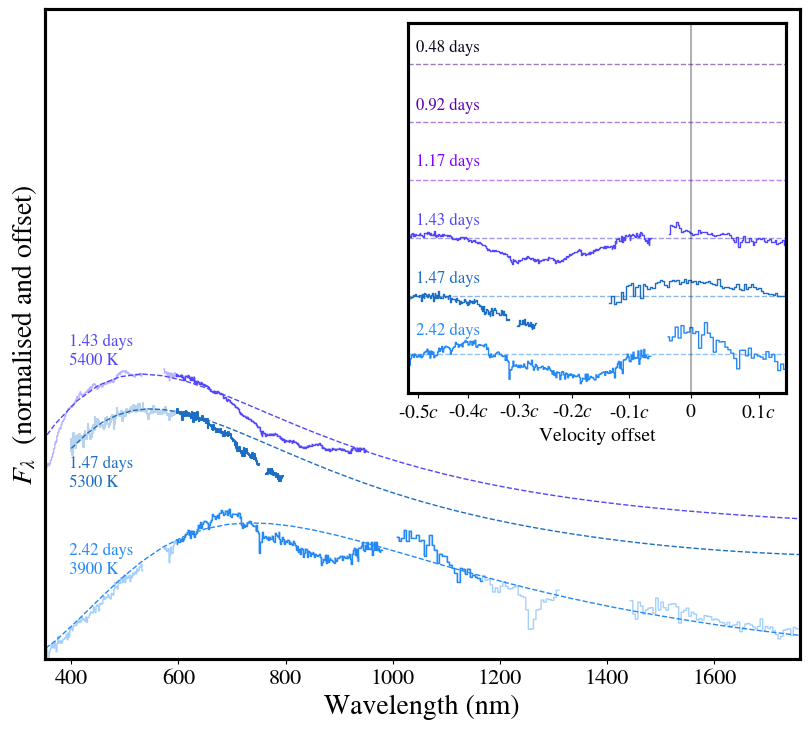

In [32]:
if_NIR = True
NIR_cut = 9500

if_early_data = True

from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.99,6)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(8.5,7.7) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
axins = inset_axes(ax, width='50%', height='57%', loc='upper right')
axins.set_yticks([])
#axins.set_xticks([])
#axins.set_ylim(0.5, 1.5)
plt.axhline( 1+off_sets[0], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.4, rtot[0]) )
plt.axhline( 1+off_sets[1], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.7, rtot[0]) )
plt.axhline( 1+off_sets[2], ls='--', linewidth=1, alpha=0.5, color=get_darker(1, rtot[0]))
plt.axhline( 1+off_sets[3], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.8, r[0]) )
plt.axhline( 1+off_sets[4], ls='--', linewidth=1, alpha=0.5, color=get_darker(0.8, r[1]) )
plt.axhline( 1+off_sets[5], ls='--', linewidth=1, alpha=0.5, color=get_darker(1, r[1]) )
axins.grid()


axins.text( 6000/10, 1.1+off_sets[0] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.48 days', color=get_darker(0.1, rtot[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.1+off_sets[1] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.11+off_sets[2] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.1+off_sets[3] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=get_darker(1, r[0]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.1+off_sets[4] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.47 days', color=get_darker(0.8, r[1]), fontsize=fontsize, rotation=rotation)
axins.text( 6000/10, 1.15+off_sets[5] #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.42 days', color=get_darker(1, r[1]), fontsize=fontsize, rotation=rotation)


ratio_off_set = np.linspace(0,3.2,6)[::-1]#np.ones(10) #np.array([ 4.4, 3.95, 3.33, 2.98, 2.45,  1.85,  1.45,  1.1 ,  0.45,  0.1 ,
        #-0.40, -0.85 , -1.25]) + 0.6
#0.3*np.arange(13)[::-1] - 0.7

#np.array([10.        ,  7.74263683,  5.9948425 ,  4.64158883,  3.59381366,
        #2.7825594 ,  2.4443469,  1.3810054,  1.29154967,  1. , 0.9, 0.6, 0.4       ])
#np.logspace(0,1,10)[::-1]
#np.array([7,6,5,3.5,2.5,1.8,1])#[0.5e-16, 0]

norm = np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])
if if_early_data:
    ax.plot(wl_LDSS3/10, flux_LDSS3/norm+ratio_off_set[1],
                 color=get_darker(0.1, rtot[0]), ds='steps', label='0.48 days', alpha=0.4, linewidth=1)
    ax.plot(wl_LDSS3[(wl_LDSS3>10450*0.57) & (wl_LDSS3<10450*1.1)]/10, flux_LDSS3[(wl_LDSS3>10450*0.57) & (wl_LDSS3<10450*1.1)]/norm+ratio_off_set[1],
                 color=get_darker(0.1, rtot[0]), ds='steps', label='0.48 days', alpha=1, linewidth=1)

    ax.text(3800/10, ratio_off_set[1]+0.95 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
                 , '  0.48 days \n  11 000 K', color=get_darker(0.01, rtot[0]), fontsize=fontsize, rotation=rotation)
    ax.plot(    wl_LDSS3/10, temp_n(wl_LDSS3*1e-10, *p_ldss_i )/norm+ratio_off_set[1], 
                color=get_darker(0.1, rtot[0]), linewidth=1, ls='--' )
    axins.plot( wl_LDSS3/10, flux_LDSS3/temp_n(wl_LDSS3*1e-10, *p_ldss )+off_sets[0], 
               color=get_darker(0.1, rtot[0]), linewidth=1, ls='-', ds='steps' )


#norm = np.max(flux_MagE[flux_MagE==flux_MagE])
#ax.plot(wl_MagE/10 , flux_MagE/norm+ratio_off_set[1], 
#             color=get_darker(0.4, rtot[0]), ds='steps', label='0.53 days', alpha=0.5)
#ax['A'].text(9000/10, np.max(flux_MagE[(wl_MagE>6900) & (wl_MagE<22000)])/np.max(flux_MagE[flux_MagE==flux_MagE])+
#                     ratio_off_set[1]+0.03, '0.53 days', color=get_darker(0.4, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wl_MagE/10, temp_n(wl_MagE*1e-10, *p_mage )/norm+ratio_off_set[1], 
#            color=get_darker(0.4, r[0]), linewidth=1, ls='--' )
#axins.plot( wl_MagE/10, flux_MagE/temp_n(wl_MagE*1e-10, *p_mage )+off_sets[1], 
#           color=get_darker(0.4, rtot[0]), linewidth=1, ls='-', ds='steps' )


    norm = np.max(flux_ANU[flux_ANU==flux_ANU])
    ax.plot(wav_ANU/10 , 0.8*flux_ANU/norm+ratio_off_set[2], 
                 color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days', alpha=0.4, linewidth=1)
    ax.plot(wav_ANU[((wav_ANU>10450*0.57) & (wav_ANU<10450*1.1)) | (wav_ANU!=wav_ANU)]/10 , 0.8*flux_ANU[((wav_ANU>10450*0.57) & (wav_ANU<10450*1.1)) | (wav_ANU!=wav_ANU)]/norm+ratio_off_set[2], 
                 color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days', alpha=1, linewidth=1)


    ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
                 , '  0.92 days \n  6800 K', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
    ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
                color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )
    axins.plot( wav_ANU/10, flux_ANU/temp_n(wav_ANU*1e-10, *p_ANU )+off_sets[1], 
               color=get_darker(0.7, rtot[0]), linewidth=1, ls='-', ds='steps' )


    ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
                 color=get_darker(1, rtot[0]), ds='steps', label='1.17 days', alpha=0.4, linewidth=1)
    #ax.plot(wl_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) | (f_SALT!=f_SALT)]/10 , f_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) | (f_SALT!=f_SALT)]/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
    #             color=get_darker(1, rtot[0]), ds='steps', label='1.18 days', alpha=1, linewidth=1)
    ax.plot(wl_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1))]/10 , f_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) ]/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
                 color=get_darker(1, rtot[0]), ds='steps', label='1.17 days', alpha=1, linewidth=1)


    ax.plot(    wl_SALT[f_SALT==f_SALT]/10, temp_n(wl_SALT[f_SALT==f_SALT]*1e-10, *p_SALT )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                    color=get_darker(1, rtot[0]), linewidth=1, ls='--' )
    axins.plot( wl_SALT/10, f_SALT/temp_n(wl_SALT*1e-10, *p_SALT)+off_sets[2], 
                     color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )
    ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
                 , '  1.17 days \n  6400 K', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '  1.43 days \n  5400 K', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+0.30 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '  1.47 days \n  5300 K', color=get_darker(0.8, r[1]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.42 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '  2.42 days \n  3900 K', color=r[1], fontsize=fontsize, rotation=rotation)

#pickle_in = open("../Kilonova/Data/Early_chains/SALT_21nov_params.pkl","rb") #OB1_3_peaks_100walkers
#p1 = pickle.load(pickle_in)
#p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0
#ax.plot(    wl_SALT/10, residual(p1, wl_SALT*1e-10 )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
#                color=get_darker(1, r[0]), linewidth=1, ls='--' )
#axins.plot( wl_SALT/10, f_SALT/residual(p1, wl_SALT*1e-10)+off_sets[2], 
#                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )

plt.plot()
#ax['A'].text(9000/10, np.max(f_SALT[(f_SALT==f_SALT) & (wl_SALT>7300) & (wl_SALT<22000)])/np.max(f_SALT[f_SALT==f_SALT])+
 #                    ratio_off_set[3]+0.03, '1.18 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

for i in [0,1,2]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    #mask2 = ((wl > 13100) & (wl < 14400)) 
    #flux2[mask] = np.nan; error2[mask] = np.nan
    #wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, ~mask, 20)
    #wl10, flux10, error10,_ = bin_spectrum(wl2, flux2, error2, mask, 10)
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50[wl50<NIR_cut]/10, flux50[wl50<NIR_cut]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>10450*0.57) & (wl50<NIR_cut)]/10, flux50[(wl50>10450*0.57) & (wl50<NIR_cut)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
     
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        axins.plot( wl50/10, 
                 flux50/residual(p1, wl50*1e-10)+off_sets[3], 
                color=r[i], linewidth=1, ls='-', ds='steps' )

        if if_NIR: 
            ax.plot(wl50[wl50>NIR_cut]/10, (flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4])[wl50>NIR_cut], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
            ax.plot(wl50[(wl50>NIR_cut) & (wl50<10450*1.12)]/10, flux50[(wl50>NIR_cut) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label=str(i+1.4)+' days', linewidth=1)
  
        
    if (i==1): 
        
        shift_down = -0.2
        
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift_down, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift_down, #(convolve(flux2, g40, fill_value=+np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0

        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift_down, 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        axins.plot( wl50/10, 
                 flux50/residual(p1, wl50*1e-10)+off_sets[5], 
                color=r[i], linewidth=1, ls='-', ds='steps' )

        
shift_up = 0.4
#ax.plot(lam_op/10, flux_fit_op/np.max(flux_fit_op)           + shift_up, color=get_darker(0.9, r[0]), alpha=0.5, ls='--')
ax.plot(lam_op[1:-1]/10, flam_op[1:-1]/np.max(flux_fit_op)   + shift_up, color=get_darker(0.8, r[1]), alpha=0.3, ds='steps')
ax.plot(lam_op[lam_op>10450*0.57]/10, flam_op[lam_op>10450*0.57]/np.max(flux_fit_op)   + shift_up, color=get_darker(0.8, r[1]), alpha=1, ds='steps')

if if_NIR:
    ax.plot(lam_nir[1:-1]/10, flam_nir[1:-1]/np.max(flux_fit_op) + shift_up, color=get_darker(0.8, r[1]), alpha=0.3, ds='steps')
    ax.plot(lam_nir[lam_nir<10450*1.12]/10, flam_nir[lam_nir<10450*1.12]/np.max(flux_fit_op) + shift_up, color=get_darker(0.8, r[1]), alpha=1, ds='steps')

#ax.plot(lam_nir/10, flux_fit_nir/np.max(flux_fit_op)         + shift_up, color=get_darker(0.9, r0]), alpha=0.5, ls='--')
ax.plot(wl_both/10, flux_fit_both/np.max(flux_fit_op)         + shift_up, color=get_darker(0.8, r[1]), alpha=1, ls='--', linewidth=1)

axins.plot( lam_nir/10, flam_nir/flux_fit_nir+off_sets[4], 
                color=get_darker(0.8, r[1]), linewidth=1, ls='-', ds='steps' )
axins.plot( lam_op/10, flam_op/flux_fit_op+off_sets[4], 
                color=get_darker(0.8, r[1]), linewidth=1, ls='-', ds='steps' )



ax.set_xlim(350, 1760)#, 
ax.set_ylim(-0.1, 3.80)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)')
#plt.yscale('log')


import matplotlib.ticker as mticker
x_ticks_bcd = [700, 750, 800, 900, 1000, 1100]
x_tick_labels_bcd = ['', '', '', '','', ''], 
#x_tick_labels_bcd = [['600', '700'] , ['', '750', '', '900','', '1100', ''], 
#                     ['', '1300', '', '1600', '', '2000', '']]

#for axis, ticks, labels in zip([ax['B'], ax['C'], ax['E']], x_ticks_bcd, x_tick_labels_bcd):
#axins.set_xscale('log'); 
#axins.set_xticks(ticks); axins.set_xticklabels(labels)
axins.xaxis.set_minor_formatter(mticker.NullFormatter())
axins.set_xlim(587, 1200)
axins.set_ylim(0.5,3.3)

#ax['B'].set_xticks([760*(i+1) for i in [-0.2, -0.1, 0, 0.1]])
#ax['B'].set_xticklabels(['-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)
#ax['B'].set_xlabel('Velocity offset', fontsize=16)

beta = np.linspace(-0.999, 0.9999, 1000)
rel_doppler = np.sqrt(1-beta**2)*1/(1-beta)
from scipy.interpolate import interp1d
interp1 = interp1d(beta, 1/rel_doppler)([0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1])

axins.set_xticks([1045*i for i in interp1])
axins.set_xticklabels([#'', '-0.4c', 
    '-0.5$c$', '-0.4$c$', '-0.3$c$', '-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)
axins.set_xlabel('Velocity offset', fontsize=14)

ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)')
plt.tight_layout()

axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/Sr_feature_emergence_with_gemini_closer_withoutNIR_without_early.png', dpi=300)


5360
Binning image by a factor: 50
5440.8967947121055
Binning image by a factor: 16


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_22191/2290422681.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 10
Binning image by a factor: 80
3935.619453803755
Binning image by a factor: 80
3419.5184704387616
Binning image by a factor: 80
3229.356686107796


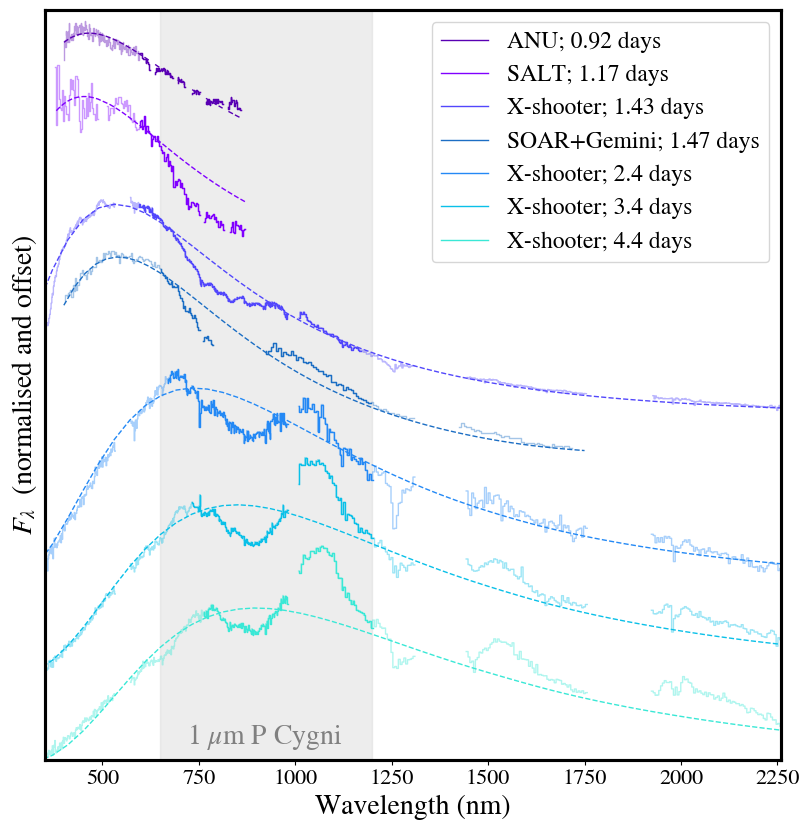

In [70]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]
n_steps = 9
off_sets = np.linspace(-0.2,1.99,n_steps)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(8.5,8.7) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
#axins = inset_axes(ax, width='50%', height='57%', loc='upper right')
#axins.set_yticks([])
#axins.set_xticks([])
#axins.set_ylim(0.5, 1.5)
#axins.grid()



ratio_off_set = np.linspace(0,3.2,n_steps)[::-1]#np.ones(10) #np.array([ 4.4, 3.95, 3.33, 2.98, 2.45,  1.85,  1.45,  1.1 ,  0.45,  0.1 ,
        #-0.40, -0.85 , -1.25]) + 0.6
#0.3*np.arange(13)[::-1] - 0.7

#np.array([10.        ,  7.74263683,  5.9948425 ,  4.64158883,  3.59381366,
        #2.7825594 ,  2.4443469,  1.3810054,  1.29154967,  1. , 0.9, 0.6, 0.4       ])
#np.logspace(0,1,10)[::-1]
#np.array([7,6,5,3.5,2.5,1.8,1])#[0.5e-16, 0]

norm = np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])
#ax.plot(wl_LDSS3/10, flux_LDSS3/norm+ratio_off_set[1],
#             color=get_darker(0.1, rtot[0]), ds='steps', label='0.48 days', alpha=0.4, linewidth=1)
#ax.plot(wl_LDSS3[(wl_LDSS3>10450*0.57) & (wl_LDSS3<10450*1.1)]/10, flux_LDSS3[(wl_LDSS3>10450*0.57) & (wl_LDSS3<10450*1.1)]/norm+ratio_off_set[1],
#             color=get_darker(0.1, rtot[0]), ds='steps', label='0.48 days', alpha=1, linewidth=1)

#ax.text(3800/10, ratio_off_set[1]+0.95 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
 #            , '0.48 days; \n  11 000 K', color=get_darker(0.01, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wl_LDSS3/10, temp_n(wl_LDSS3*1e-10, *p_ldss_i )/norm+ratio_off_set[1], 
 #           color=get_darker(0.1, rtot[0]), linewidth=1, ls='--' )
#axins.plot( wl_LDSS3/10, flux_LDSS3/temp_n(wl_LDSS3*1e-10, *p_ldss )+off_sets[0], 
 #          color=get_darker(0.1, rtot[0]), linewidth=1, ls='-', ds='steps' )


#norm = np.max(flux_MagE[flux_MagE==flux_MagE])
#ax.plot(wl_MagE/10 , flux_MagE/norm+ratio_off_set[1], 
#             color=get_darker(0.4, rtot[0]), ds='steps', label='0.53 days', alpha=0.5)
#ax['A'].text(9000/10, np.max(flux_MagE[(wl_MagE>6900) & (wl_MagE<22000)])/np.max(flux_MagE[flux_MagE==flux_MagE])+
#                     ratio_off_set[1]+0.03, '0.53 days', color=get_darker(0.4, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wl_MagE/10, temp_n(wl_MagE*1e-10, *p_mage )/norm+ratio_off_set[1], 
#            color=get_darker(0.4, r[0]), linewidth=1, ls='--' )
#axins.plot( wl_MagE/10, flux_MagE/temp_n(wl_MagE*1e-10, *p_mage )+off_sets[1], 
#           color=get_darker(0.4, rtot[0]), linewidth=1, ls='-', ds='steps' )


norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.8*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)
ax.plot(wav_ANU[((wav_ANU>10450*0.57) & (wav_ANU<10450*1.1)) | (wav_ANU!=wav_ANU)]/10 , 0.8*flux_ANU[((wav_ANU>10450*0.57) & (wav_ANU<10450*1.1)) | (wav_ANU!=wav_ANU)]/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', label='ANU; 0.92 days', alpha=1, linewidth=1)


#ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
 #            , '0.92 days; \n  6800 K', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )
#axins.plot( wav_ANU/10, flux_ANU/temp_n(wav_ANU*1e-10, *p_ANU )+off_sets[1], 
 #          color=get_darker(0.7, rtot[0]), linewidth=1, ls='-', ds='steps' )


ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)
#ax.plot(wl_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) | (f_SALT!=f_SALT)]/10 , f_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) | (f_SALT!=f_SALT)]/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
#             color=get_darker(1, rtot[0]), ds='steps', label='1.18 days', alpha=1, linewidth=1)
ax.plot(wl_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1))]/10 , f_SALT[((wl_SALT>10450*0.57) & (wl_SALT<10450*1.1)) ]/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='SALT; 1.17 days', alpha=1, linewidth=1)


ax.plot(    wl_SALT[f_SALT==f_SALT]/10, temp_n(wl_SALT[f_SALT==f_SALT]*1e-10, *p_SALT )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=1, ls='--' )
print(p['T'].value)

#axins.plot( wl_SALT/10, f_SALT/temp_n(wl_SALT*1e-10, *p_SALT)+off_sets[2], 
#                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )
#ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
 #            , '1.17 days; \n  6400 K', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

#ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
 #            , '1.43 days; \n  5400 K', color=r[0], fontsize=fontsize, rotation=rotation)

#ax.text(3800/10, ratio_off_set[4]+0.30 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
 #            , '1.47 days; \n  5300 K', color=get_darker(0.8, r[1]), fontsize=fontsize, rotation=rotation)

#ax.text(3800/10, ratio_off_set[5]+0.42 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
 #            , '2.42 days; \n  3900 K', color=r[1], fontsize=fontsize, rotation=rotation)

#pickle_in = open("../Kilonova/Data/Early_chains/SALT_21nov_params.pkl","rb") #OB1_3_peaks_100walkers
#p1 = pickle.load(pickle_in)
#p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0
#ax.plot(    wl_SALT/10, residual(p1, wl_SALT*1e-10 )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
#                color=get_darker(1, r[0]), linewidth=1, ls='--' )
#axins.plot( wl_SALT/10, f_SALT/residual(p1, wl_SALT*1e-10)+off_sets[2], 
#                 color=get_darker(1, rtot[0]), linewidth=1, ls='-', ds='steps' )

#plt.plot()
#ax['A'].text(9000/10, np.max(f_SALT[(f_SALT==f_SALT) & (wl_SALT>7300) & (wl_SALT<22000)])/np.max(f_SALT[f_SALT==f_SALT])+
 #                    ratio_off_set[3]+0.03, '1.18 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

    
    
for i in [0,1,2,3,4]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    #mask2 = ((wl > 13100) & (wl < 14400)) 
    #flux2[mask] = np.nan; error2[mask] = np.nan
    #wl2, flux2, error2,_ = bin_spectrum(wl2, flux2, error2, ~mask, 20)
    #wl10, flux10, error10,_ = bin_spectrum(wl2, flux2, error2, mask, 10)
    
    if (i == 0): 
        shift_down = -0.2

        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift_down, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        
        ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift_down, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', label='X-shooter; 1.43 days', linewidth=1)
        
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
     
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]+shift_down, 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        print(p1['T'].value)
        
        #axins.plot( wl50/10, 
        #         flux50/residual(p1, wl50*1e-10)+off_sets[3], 
        #        color=r[i], linewidth=1, ls='-', ds='steps' )
        
        ratio_off_set[5] = ratio_off_set[5]-0.07

        p['amp1'].value = 0
        p['T'].value = 5360
        p['N'].value = 1.3338e-29 * 1.05
        path_VIS = 'nicholl_optical_spectra/gw170817_day1.5_SOAR_restframe_dered.txt'
        lam, flam = np.loadtxt(path_VIS).T
        exc_reg = (~((lam > 7510) & (lam < 7650)))
        lam_op,flam_op,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 16)

        flux_fit_op = residual(p, lam_op[1:-1]*1e-10)
        ax.plot(lam_op[1:-1]/10, flam_op[1:-1]/np.max(residual(p, wl_GEMINI*1e-9))+ratio_off_set[5],
                 color=get_darker(0.8, r[1]), ds='steps', linewidth=1, alpha=0.4)

        ax.plot((lam_op[1:-1]/10)[lam_op[1:-1]/10>650], 
                (flam_op[1:-1]/np.max(residual(p, wl_GEMINI*1e-9)))[lam_op[1:-1]/10>650]+ratio_off_set[5],
                 color=get_darker(0.8, r[1]), ds='steps', label='SOAR+Gemini; 1.47 days', linewidth=1, alpha=1)


        path_NIR = 'CHORNOCK_NIR_final/gw170817-gemini-day1.5-dered-sca.dat'
        lam, flam = np.loadtxt(path_NIR).T
        exc_reg = (~((lam > 13100) & (lam < 14300))) & (lam < 17200)
        lam_nir,flam_nir,_,_ = bin_spectrum(lam,flam,np.ones_like(flam), ~exc_reg, 10)
        flux_fit_nir = residual(p, lam_nir[1:-1]*1e-10)

        ax.plot( (lam_nir[1:-1]/10)[lam_nir[1:-1]/10<1200], 
                (flam_nir[1:-1]/np.max(residual(p, wl_GEMINI*1e-9)))[lam_nir[1:-1]/10<1200]+ratio_off_set[5], 
                 color=get_darker(0.8, r[1]), ds='steps', linewidth=1, alpha=1)

        ax.plot(lam_nir[1:-1]/10, flam_nir[1:-1]/np.max(residual(p, wl_GEMINI*1e-9))+ratio_off_set[5], 
                 color=get_darker(0.8, r[1]), ds='steps', linewidth=1, alpha=0.4)


        wl_GEMINI = np.linspace(400, 1750)
        ax.plot(wl_GEMINI, residual(p, wl_GEMINI*1e-9)/np.max(flux_fit_op)+ratio_off_set[5], alpha=1, 
                 color=get_darker(0.8, r[1]), linewidth=1, ls='--')
        
    if (i==1): 
        
        shift_down = -0.18
        
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]+shift_down, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        ax.plot(wl50[(wl50>10450*0.64) & (wl50<10450*1.15)]/10, 
                flux50[(wl50>10450*0.64) & (wl50<10450*1.15)]/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down,
                 color=r[i] , alpha=1, ds='steps', linewidth=1, label='X-shooter; 2.4 days')
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0

        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down, 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        print(p1['T'].value)
        
        #axins.plot( wl50/10, 
        #         flux50/residual(p1, wl50*1e-10)+off_sets[5], 
        #        color=r[i], linewidth=1, ls='-', ds='steps' )
        
    if (i==2): 
        
        shift_down = -0.18
        
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]+shift_down, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        ax.plot(wl50[(wl50>10450*0.70) & (wl50<10450*1.15)]/10, 
                flux50[(wl50>10450*0.70) & (wl50<10450*1.15)]/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down, #(convolve(flux2, g40, fill_value=+np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', linewidth=1, label='X-shooter; 3.4 days')
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        pickle_in = open('../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0

        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down, 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        print(p1['T'].value)

        
    if (i==3): 
        
        shift_down = -0.18
        
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        ax.plot(wl50[(wl50>10450*0.73) & (wl50<10450*1.15)]/10, 
                flux50[(wl50>10450*0.73) & (wl50<10450*1.15)]/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down, #(convolve(flux2, g40, fill_value=+np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=1, ds='steps', linewidth=1, label='X-shooter; 4.4 days')
        
        #ax['A'].text(20050/10, np.max(flux50[(wl50>20050) & (wl50<22000)])/np.max(flux50[flux50==flux50])+
         #            ratio_off_set[i+4]+0.03, str(i+1.4)+' days', color=r[i], fontsize=fontsize, rotation=rotation)
        
        pickle_in = open('../Kilonova/data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['tau'].value = 0; p1['amp1'].value = 0; p1['amp2'].value = 0

        ax.plot( np.linspace( 330, 2300 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9 ) )/np.max(flux50[flux50==flux50])+
                ratio_off_set[i+5]+shift_down, 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        print(p1['T'].value)
        #axins.plot( wl50/10, 
        #         flux50/residual(p1, wl50*1e-10)+off_sets[5], 
        #        color=r[i], linewidth=1, ls='-', ds='steps' )

        
shift_up = 1.15


#ax.plot(lam_op/10, flux_fit_op/np.max(flux_fit_op)           + shift_up, color=get_darker(0.9, r[0]), alpha=0.5, ls='--')
#ax.plot(lam_op[1:-1]/10, flam_op[1:-1]/np.max(flux_fit_op)   + shift_up, color=get_darker(0.8, r[1]), alpha=0.3, ds='steps')
#ax.plot(lam_op[lam_op>10450*0.57]/10, flam_op[lam_op>10450*0.57]/np.max(flux_fit_op)   + shift_up, color=get_darker(0.8, r[1]), alpha=1, ds='steps')

#ax.plot(lam_nir[1:-1]/10, flam_nir[1:-1]/np.max(flux_fit_op) + shift_up, color=get_darker(0.8, r[1]), alpha=0.3, ds='steps')
#ax.plot(lam_nir[lam_nir<10450*1.12]/10, flam_nir[lam_nir<10450*1.12]/np.max(flux_fit_op) + shift_up, color=get_darker(0.8, r[1]), alpha=1, ds='steps')

#ax.plot(lam_nir/10, flux_fit_nir/np.max(flux_fit_op)         + shift_up, color=get_darker(0.9, r0]), alpha=0.5, ls='--')
#ax.plot(wl_both/10, flux_fit_both/np.max(flux_fit_op)         + shift_up, color=get_darker(0.8, r[1]), alpha=1, ls='--', linewidth=1)

#axins.plot( lam_nir/10, flam_nir/flux_fit_nir+off_sets[4], 
#                color=get_darker(0.8, r[1]), linewidth=1, ls='-', ds='steps' )
#axins.plot( lam_op/10, flam_op/flux_fit_op+off_sets[4], 
#                color=get_darker(0.8, r[1]), linewidth=1, ls='-', ds='steps' )



ax.set_xlim(350, 2260)#, 
ax.set_ylim(-0.15, 3.25)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)')
#plt.yscale('log')


import matplotlib.ticker as mticker
x_ticks_bcd = [700, 750, 800, 900, 1000, 1100]
x_tick_labels_bcd = ['', '', '', '','', ''], 
#x_tick_labels_bcd = [['600', '700'] , ['', '750', '', '900','', '1100', ''], 
#                     ['', '1300', '', '1600', '', '2000', '']]

#for axis, ticks, labels in zip([ax['B'], ax['C'], ax['E']], x_ticks_bcd, x_tick_labels_bcd):
#axins.set_xscale('log'); 
#axins.set_xticks(ticks); axins.set_xticklabels(labels)
#axins.xaxis.set_minor_formatter(mticker.NullFormatter())
#axins.set_xlim(587, 1200)
#axins.set_ylim(0.5,2.7)

#ax['B'].set_xticks([760*(i+1) for i in [-0.2, -0.1, 0, 0.1]])
#ax['B'].set_xticklabels(['-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)
#ax['B'].set_xlabel('Velocity offset', fontsize=16)

beta = np.linspace(-0.999, 0.9999, 1000)
rel_doppler = np.sqrt(1-beta**2)*1/(1-beta)
from scipy.interpolate import interp1d
interp1 = interp1d(beta, 1/rel_doppler)([0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1])

#axins.set_xticks([1045*i for i in interp1])
#axins.set_xticklabels([#'', '-0.4c', 
#    '-0.5$c$', '-0.4$c$', '-0.3$c$', '-0.2$c$', '-0.1$c$', '0', '0.1$c$'], fontsize=14)
#axins.set_xlabel('Velocity offset', fontsize=14)

ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)')
plt.tight_layout()
plt.legend(frameon=True, fontsize=17)
plt.fill_between([650, 1200], [5,5], [-5,-5], alpha=0.4, color='lightgrey')
plt.text(719, ax.get_ylim()[0]+0.07, r'1 $\mu$m P Cygni', color='grey' )
#plt.xscale('log')
#axins.axvline(1045, color='k', alpha=0.3)

#plt.savefig('Pictures/Sr_feature_emergence_helium_paper_gemini_included.pdf', dpi=300)


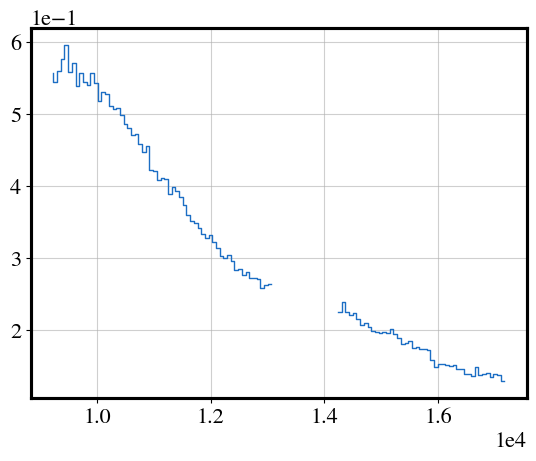

In [24]:
plt.plot(lam_nir[1:-1], flam_nir[1:-1]/np.max(flux_fit_op), alpha=1, 
         color=get_darker(0.8, r[1]), ds='steps', linewidth=1)



In [39]:
p

/opt/anaconda3/lib/python3.9/site-packages/lmfit/printfuncs.py:322: RuntimeWarning: divide by zero encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


name,value,standard error,relative error,initial value,min,max,vary
T,5440.89679,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,126000.000,,,126000,-inf,inf,False
tau,0.00000000,4.75750986,(inf%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,0.01110866,0.03904019,(351.44%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.00000000,0.00724750,(inf%),0.26169986240919846,0.00000000,5.00000000,True


In [286]:
2.45*0.99

2.4255

In [151]:
(1.47/1.43)**(-0.65), (1.47/1.43)**2

(0.9822276528942294, 1.0567264902929236)

[6.45251404e+03 2.03811026e-30]


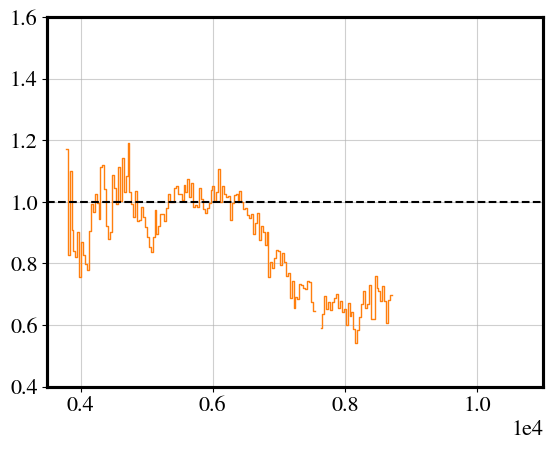

In [ ]:
up, low = 6400, 4200
p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<up) & (wl_SALT>low)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<up) & (wl_SALT>low)], p0=[6000, 1e-29])
plt.plot(wl_SALT, temp_n(wl_SALT*1e-10, *p_SALT))
print(p_SALT)

plt.plot(wl_SALT, f_SALT/temp_n(wl_SALT*1e-10, *p_SALT), ds='steps', linewidth=1)
plt.ylim(0.4, 1.6)
plt.xlim(3500, 11000)
plt.axhline(1, ls='--', color='k')

<Parameter 'tau', value=130 +/- 42.8, bounds=[0:1000.0]>
Binning image by a factor: 50


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5907/844939264.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5907/844939264.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5907/844939264.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_5907/844939264.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 50
Binning image by a factor: 80


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


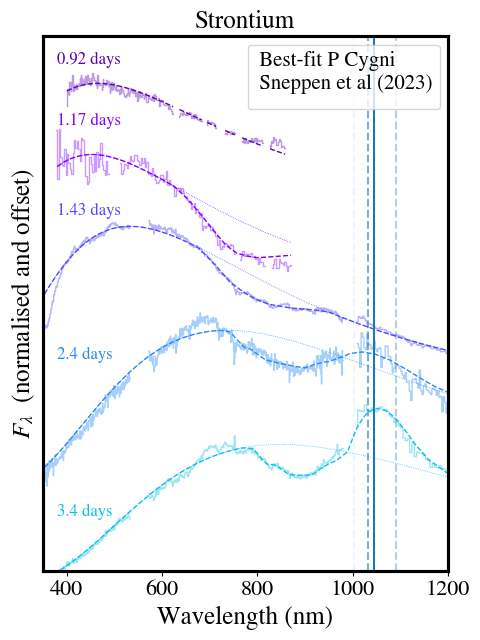

In [43]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.7,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,6.8) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.0,7)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.8*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p1 = emcee_res.params
p1['T'].value = 6400
p1['N'].value = 1.29e-30
p1['vmax'].value = 0.39
p1['tau'].value = 130
print(p1['tau'])
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p1, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=1, ls='--' )

p1['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p1, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=0.5, ls='dotted' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.00)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')

plt.title('Strontium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.tight_layout()

plt.axvline(10036.65/10, ls='--', alpha=1/13.8)
plt.axvline(10327/10, ls='--', alpha=8.1/13.8)
plt.axvline(10914.887/10, ls='--', alpha=4.7/13.8)
plt.axvline(1045, ls='-', alpha=1)

plt.legend(fontsize=12, title=' Best-fit P Cygni \n Sneppen et al (2023)', title_fontsize=15, loc=1)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/Sr_feature_emergence_Comparison_with_He_legend.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

<Parameter 'tau', value=130 +/- 42.8, bounds=[0:1000.0]>
Binning image by a factor: 50


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 50
Binning image by a factor: 80


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Binning image by a factor: 80


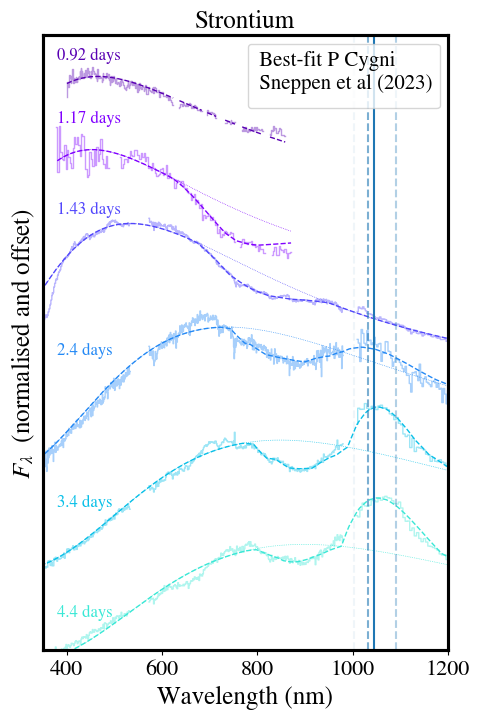

In [380]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.9,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,7.6) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.8,8)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.8*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p1 = emcee_res.params
p1['T'].value = 6400
p1['N'].value = 1.29e-30
p1['vmax'].value = 0.39
p1['tau'].value = 130
print(p1['tau'])
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p1, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=1, ls='--' )

p1['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p1, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=0.5, ls='dotted' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[7]+0.3 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '4.4 days', color=r[3], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2,3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    if (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.70)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')

plt.title('Strontium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.tight_layout()

plt.axvline(10036.65/10, ls='--', alpha=1/13.8)
plt.axvline(10327/10, ls='--', alpha=8.1/13.8)
plt.axvline(10914.887/10, ls='--', alpha=4.7/13.8)
plt.axvline(1045, ls='-', alpha=1)

plt.legend(fontsize=12, title=' Best-fit P Cygni \n Sneppen et al (2023)', title_fontsize=15, loc=1)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/Sr_feature_emergence_Comparison_with_He_legend_4days.png', dpi=300)

#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

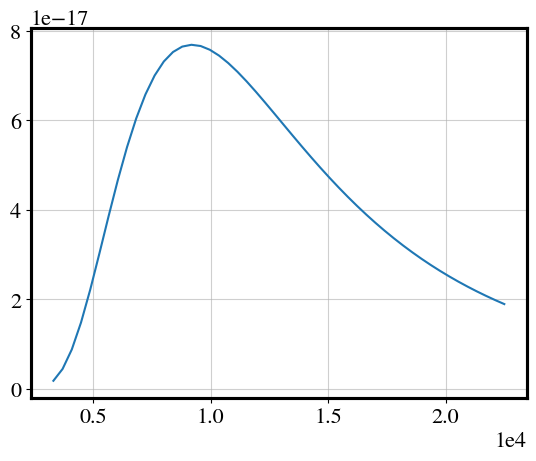

In [15]:
T = np.array([5440.8967947121055,
 3935.619453803755,
 3419.5184704387616,
 3229.356686107796,
 3074.4490750302894])

N = np.array([1.3338150746859284e-29,
 2.752046990957482e-29,
 3.6499222422992864e-29,
 3.129516127585633e-29,
 3.609077688618241e-29])
n_days = [1.427, 2.417, 3.413, 4.40, 5.40]

T_interp = interp1d(n_days, T)(4.9)
N_interp = interp1d(n_days, N)(4.9)

plt.plot( np.linspace(3300, 22500), 1.8*N_interp*temp(np.linspace(3300, 22500)*1e-10,T_interp) )


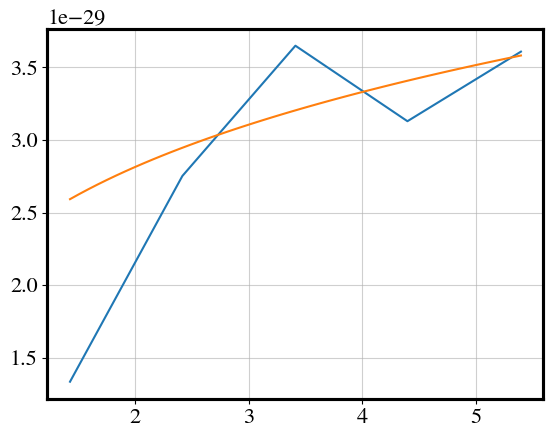

<Parameter 'T', value=5989.442056587274 +/- 93.4, bounds=[2500:7500]>
Binning image by a factor: 50


/Users/asnep1/Desktop/Present/Spectral Series (AT2017gfo)/pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
/Users/asnep1/Desktop/Present/Spectral Series (AT2017gfo)/pcygni_5.py:546: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/

Binning image by a factor: 80
Binning image by a factor: 80


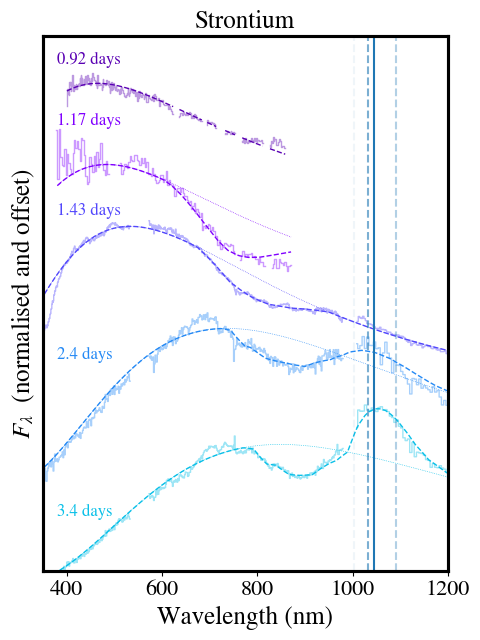

In [112]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.7,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,6.8) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.0,7)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.8*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.17 days', alpha=0.4, linewidth=1)
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p1 = emcee_res.params
print(p1['T'])
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p1, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=1, ls='--' )

p1['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p1, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=0.5, ls='dotted' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=0.5, ls='dotted' )
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.00)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')

plt.title('Strontium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.tight_layout()

plt.axvline(10036.65/10, ls='--', alpha=1/13.8)
plt.axvline(10327/10, ls='--', alpha=8.1/13.8)
plt.axvline(10914.887/10, ls='--', alpha=4.7/13.8)
plt.axvline(1045, ls='-', alpha=1)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/Sr_feature_emergence_Comparison_with_He.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

Binning image by a factor: 15


/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:113: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:115: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
/var/folders/00/qd_bjjwx76ncz89w4fbwdq2w0000gq/T/ipykernel_1742/844939264.py:115: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


Binning image by a factor: 20
Binning image by a factor: 20


<Figure size 720x500 with 0 Axes>

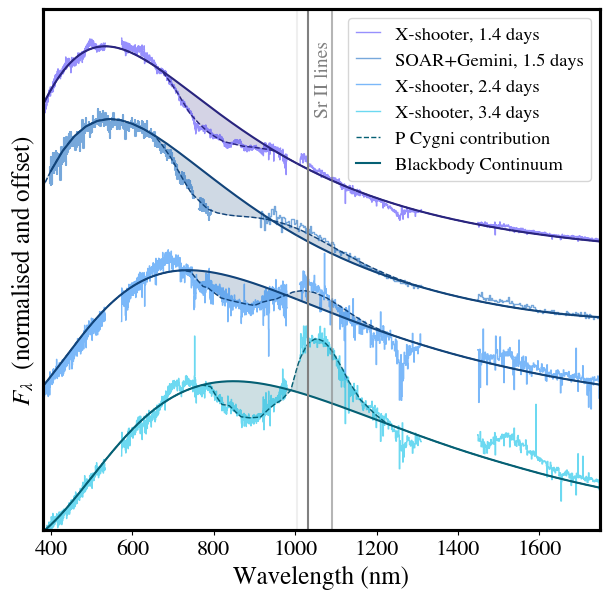

In [231]:
plt.figure(figsize=(7.2,5.0))
plt.figure(figsize=(6.5,6.4))
ratio_off_set = np.linspace(0,2.5,8)[::-1]

for i in [0,1,2]:
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 15)

        plt.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.6, ds='steps', label='X-shooter, '+str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['amp1'].value = 0
        p1['amp2'].value = 0

        ploty =residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4]
        plt.plot( np.linspace( 330, 2300, 1000 ), 
                 ploty, 
                color=get_darker(0.5, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0

        plt.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(0.5, r[i]), linewidth=1.5, ls='-' )        
        plt.fill_between( np.linspace( 330, 2300, 1000 ), residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                         ploty, color=get_darker(0.5, r[i]), alpha=0.2 )
        

        
        
        
        plt.plot(lam_op[1:-1]/10, flam_op[1:-1]/np.max(flux_fit_op)   + ratio_off_set[5] , color=get_darker(0.8, r[1]), alpha=0.6, ds='steps')
        #plt.plot(lam_op[lam_op>10450*0.57]/10, flam_op[lam_op>10450*0.57]/np.max(flux_fit_op)  + ratio_off_set[5], color=get_darker(0.8, r[1]), alpha=1, ds='steps')

        plt.plot(lam_nir[1:-1]/10, flam_nir[1:-1]/np.max(flux_fit_op) + ratio_off_set[5], color=get_darker(0.8, r[1]), alpha=0.6, ds='steps'
                , label='SOAR+Gemini, '+str(1.5)+' days', linewidth=1)
        #plt.plot(lam_nir[lam_nir<10450*1.12]/10, flam_nir[lam_nir<10450*1.12]/np.max(flux_fit_op) + ratio_off_set[5], color=get_darker(0.8, r[1]), alpha=1, ds='steps')

        #ax.plot(lam_nir/10, flux_fit_nir/np.max(flux_fit_op)         + shift_up, color=get_darker(0.9, r0]), alpha=0.5, ls='--')
        plt.plot(wl_both/10, flux_fit_both/np.max(flux_fit_op)         + ratio_off_set[5], color=get_darker(0.5, r[1]), alpha=1, ls='-', linewidth=1.5)

        pickle_in = open('../Kilonova/data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1['T'].value = p1['T'].value*0.978
        p1['N'].value = p1['N'].value*(1.056)**2
        p1['vmax'].value = p1['vmax'].value * 1.05
        p1['amp1'].value=0
        p1['occult'].value = 1.0

        pcopy = p1.copy()
        pcopy['tau'].value = 0

        plt.plot( np.linspace( 330, 2300, 1000 ), 
                         residual(p1, np.linspace( 330e-9, 2300e-9, 1000    ) )/np.max(flux_fit_op)+ratio_off_set[5], 
                        color=get_darker(0.5, r[1]), linewidth=1, ls='--' )


        plt.fill_between( np.linspace( 330, 2300, 1000 ), 
                         residual(p1, np.linspace( 330e-9, 2300e-9, 1000    ) )/np.max(flux_fit_op)+ratio_off_set[5],
                         residual(pcopy, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux_fit_op)+ratio_off_set[5],
                         color=get_darker(0.5, r[1]), alpha=0.2 )


        
    if (i == 1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        plt.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+5], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.6, ds='steps', linewidth=1, label='X-shooter, '+str(i+1.4)+' days')
        
        pickle_in = open('../Kilonova/data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        p1['amp1'].value = 0
        p1['amp2'].value = 0

        ploty =residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]
        plt.plot( np.linspace( 330, 2300, 1000 ), 
                 ploty, 
                color=get_darker(0.5, r[i]), linewidth=1, ls='--' )
        
        p1['tau'].value = 0

        
        plt.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+5], 
                color=get_darker(0.5, r[i]), linewidth=1.5, ls='-' )
        
        plt.fill_between( np.linspace( 330, 2300, 1000 ), residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+5],
                         ploty, color=get_darker(0.5, r[i]), alpha=0.2 )
        
if (i == 2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        plt.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]-0.2, #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.6, ds='steps', linewidth=1, label='X-shooter, '+str(i+1.4)+' days')
        
        pickle_in = open('../Kilonova/data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params

        p1['amp1'].value = 0
        p1['amp2'].value = 0

        ploty =residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]-0.2
        plt.plot( np.linspace( 330, 2300, 1000 ), 
                 ploty, 
                color=get_darker(0.5, r[i]), linewidth=1, ls='--', label='P Cygni contribution' )
        
        p1['tau'].value = 0

        
        plt.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]-0.2, 
                color=get_darker(0.5, r[i]), linewidth=1.5, ls='-', label='Blackbody Continuum' )
        
        plt.fill_between( np.linspace( 330, 2300, 1000 ), residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+5]-0.2, 
                         ploty, color=get_darker(0.5, r[i]), alpha=0.2 )


#plt.yscale('log'), 
#plt.ylim(1e-17, 3e-16)
plt.xlim(380, 1749)
plt.ylim(-0.1, 2.2)
plt.yticks([])
plt.grid()

#plt.axvline(10036.65/10, ls='-', alpha=1/8.1, color='grey')
#plt.axvline(10327/10, ls='-', alpha=1, color='grey')
#plt.axvline(10914.887/10, ls='-', alpha=4.7/8.1, color='grey')
#plt.axvline(10450/10, ls='-', alpha=1, color='grey')

plt.xlabel('Wavelength (nm)', fontsize=18)
plt.ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.ticklabel_format(axis='x', style='plain')
#plt.xscale('log')

plt.tight_layout()
#plt.text(1580, 0.86, '1.4 days', fontsize=14, color=get_darker(0.8, r[0])) 
#plt.text(1580, 0.64, '2.4 days', fontsize=14, color=get_darker(0.8, r[1])) 
plt.text(1048, 1.74, 'Sr II lines', fontsize=14, rotation=90, color='grey')
plt.axvline(10036.65/10, ls='-', alpha=1/8.1, color='grey')
plt.axvline(10327/10, ls='-', alpha=1, color='grey')
plt.axvline(10914.887/10, ls='-', alpha=4.7/8.1, color='grey')

plt.legend(frameon=True, fontsize=13.3, loc='upper right', handlelength=1.3)
plt.savefig('Pictures/Sr_feature_emergence_Xshooter_1_with_Gemini+SOAR.png', dpi=300)